# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
from bs4 import BeautifulSoup
import json
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
import highlight_text
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mplsoccer import Pitch, VerticalPitch
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from io import BytesIO
from mplsoccer import PyPizza, add_image, FontManager
#import soccerdata as sd
import re
from unidecode import unidecode
from scipy.spatial import ConvexHull
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import ax_text, fig_text
from scipy.ndimage import gaussian_filter

pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#010b14"
text_color = 'white'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

In [2]:
import matplotlib.font_manager as fm
from mplsoccer import FontManager

# Set the path to the locally downloaded font file
font_path = r'C:\Users\acer\Documents\GitHub\IndianCitizen\ScorePredict\Score Logos-20241022T100701Z-001\Score Logos\Sora_Font\Sora-Regular.ttf'

# Add the font to matplotlib
font_prop = fm.FontProperties(fname=font_path)

# You can now use this font in your plots
fm_sora = FontManager()
#fm_sora.prop = font_prop

print("Font loaded and registered successfully!")

Font loaded and registered successfully!


# Extracting Data

### Understat

In [33]:
import understatapi
client = understatapi.UnderstatClient()

In [34]:
league = "EPL"
season = "2024"
league_data = client.league(league=league).get_match_data(season=season)

In [35]:
matches = []

for match in league_data:
    match_data = {
        'id': match['id'],
        'home_team': match['h']['title'],
        'away_team': match['a']['title'],
        'home_goals': match['goals']['h'],
        'away_goals': match['goals']['a'],
        'home_xG': match['xG']['h'],
        'away_xG': match['xG']['a'],
        'datetime': match['datetime']
        #'forecast': match['forecast']
    }
    matches.append(match_data)

# Convert the list of dictionaries into a DataFrame
matches_df = pd.DataFrame(matches)

In [36]:
matches_df['home_team'].unique()

array(['Manchester United', 'Ipswich', 'Arsenal', 'Everton',
       'Newcastle United', 'Nottingham Forest', 'West Ham', 'Brentford',
       'Chelsea', 'Leicester', 'Brighton', 'Crystal Palace', 'Fulham',
       'Manchester City', 'Southampton', 'Tottenham', 'Aston Villa',
       'Wolverhampton Wanderers', 'Bournemouth', 'Liverpool'],
      dtype=object)

In [37]:
hteam = 'Manchester City'
ateam = 'Aston Villa'
match_id = matches_df[(matches_df['home_team'] == hteam) & (matches_df['away_team'] == ateam)]['id'].iloc[0]

In [38]:
match_id

'26937'

In [39]:
shot_data = client.match(match=match_id).get_shot_data()

In [40]:
home_shots = []

for shot in shot_data['h']:
    shots_data = {
        'id': shot['id'],
        'minute': shot['minute'],
        'result': shot['result'],
        'x': shot['X'],
        'y': shot['Y'],
        'xG': shot['xG'],
        'player': shot['player'],
        'h_a': shot['h_a'],
        'situation': shot['situation'],
        'shotType': shot['shotType'],
        'player_assisted': shot['player_assisted'],
        'lastAction': shot['lastAction']
    }
    home_shots.append(shots_data)

# Convert the list of dictionaries into a DataFrame
home_shots_df = pd.DataFrame(home_shots)

In [41]:
away_shots = []

for shot in shot_data['a']:
    shots_data = {
        'id': shot['id'],
        'minute': shot['minute'],
        'result': shot['result'],
        'x': shot['X'],
        'y': shot['Y'],
        'xG': shot['xG'],
        'player': shot['player'],
        'h_a': shot['h_a'],
        'situation': shot['situation'],
        'shotType': shot['shotType'],
        'player_assisted': shot['player_assisted'],
        'lastAction': shot['lastAction']
    }
    away_shots.append(shots_data)

# Convert the list of dictionaries into a DataFrame
away_shots_df = pd.DataFrame(away_shots)

### WhoScored

In [3]:
# Put the match HTML file path here
match_html_path = "C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/HTMLs/ManCity/39.html"

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

# Extract the 'displayName' value
df['type'] = df['type'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)
df['outcomeType'] = df['outcomeType'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)
df['period'] = df['period'].apply(lambda x: x['displayName'] if isinstance(x, dict) else None)

# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4,
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})

# new column for cumulative minutes, This part is taken from the "jakeyk11.github.io" github repository and modified for my use
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()

    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
# xT = pd.read_csv("/content/xT_Grid.csv", header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'outcomeType', 'qualifiers',  'type',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot', 'cumulative_mins']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

# New Column for Team Names and Oppositon TeamNames
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats',
                   'subbedInPlayerId', 'subbedOutPeriod',
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

# adding player name, shirt no. etc info
df = df.merge(dfp, on='playerId', how='left')

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'),
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'),
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['name'] = df['name'].astype(str)
df['name'] = df['name'].apply(unidecode)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['name'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['id']
df.drop(columns=columns_to_drop2, inplace=True)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime',
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

C:\Users\acer\AppData\Local\Temp\ipykernel_12132\1229680633.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_12132\1229680633.py:207: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)


In [4]:
def classify_pass_or_carry(event_type, angle):
    if event_type == 'Pass':
        if angle <= -135 or angle >= 135:
            return 'Backward'  # Corrected Backward condition
        elif -45 < angle < 45:
            return 'Forward'
        else:
            return 'Side'
    elif event_type == 'Carry':
        if angle <= -135 or angle >= 135:
            return 'Backward'  # Corrected Backward condition
        elif -45 < angle < 45:
            return 'Forward'
        else:
            return 'Side'
    return None

# Apply the function to create new columns for Pass Type and Carry Type
df['Pass Type'] = df.apply(lambda x: classify_pass_or_carry(x['type'], x['pass_or_carry_angle']) if x['type'] == 'Pass' else None, axis=1)
df['Carry Type'] = df.apply(lambda x: classify_pass_or_carry(x['type'], x['pass_or_carry_angle']) if x['type'] == 'Carry' else None, axis=1)

df['IsCorner'] = False

# Find 'Pass' events following 'CornerAwarded' for the same team
for i, row in df.iterrows():
    if (row['type'] == 'CornerAwarded') & (row['outcomeType'] == 'Successful'):
        team = row['teamName']
        # Iterate through subsequent rows to find a valid 'Pass' for the same team
        for j in range(i + 1, len(df)):
            if df.loc[j, 'type'] == 'Pass' and df.loc[j, 'teamName'] == team:
                df.loc[j, 'IsCorner'] = True
                break

In [27]:
df.columns

Index(['index', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal_x', 'cardType_x',
       'isOwnGoal_x', 'cumulative_mins', 'isGoal_y', 'cardType_y',
       'isOwnGoal_y', 'x1_bin_xT', 'y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT',
       'start_zone_value_xT', 'end_zone_value_xT', 'xT', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'prog_pass', 'prog_carry', 'pass_or_carry_angle', 'shortName',
       'Pass Type', 'Carry Type', 'IsCorner'],
      dtype='object')

# Team Dashboard

## Match Stats

In [29]:
def match_stats(ax,team1_facecolor,team2_facecolor,team1_pos,team2_pos,team1_acc_passes,team2_acc_passes,team1_saves,team2_saves):
    df_team1 = home_shots_df[(home_shots_df.result != 'Goal') & (home_shots_df.shotType != 'Head')].copy()
    df_team2 = away_shots_df[(away_shots_df.result != 'Goal') & (away_shots_df.shotType != 'Head')].copy()
    
    df_team1_goals = home_shots_df[(home_shots_df.result == 'Goal') & (home_shots_df.shotType != 'Head')].copy()
    df_team2_goals = away_shots_df[(away_shots_df.result == 'Goal') & (away_shots_df.shotType != 'Head')].copy()
    
    df_team1_headers_goals = home_shots_df[(home_shots_df.result == 'Goal') & (home_shots_df.shotType == 'Head')].copy()
    df_team2_headers_goals = away_shots_df[(away_shots_df.result == 'Goal') & (away_shots_df.shotType == 'Head')].copy()
    
    df_team1_own_goals = home_shots_df[(home_shots_df.result == 'OwnGoal')].copy()
    df_team2_own_goals = away_shots_df[(away_shots_df.result == 'OwnGoal')].copy()
    
    df_team1_headers = home_shots_df[(home_shots_df.result != 'Goal') & (home_shots_df.shotType == 'Head')].copy()
    df_team2_headers = away_shots_df[(away_shots_df.result != 'Goal') & (away_shots_df.shotType == 'Head')].copy()
    
    team1_xg = round(home_shots_df['expectedGoals'].astype(float).sum(),2)
    team2_xg = round(away_shots_df['expectedGoals'].astype(float).sum(),2)
    
    team1_goals = df_team1_goals.shape[0] + df_team2_own_goals.shape[0] + df_team1_headers_goals.shape[0]
    team2_goals = df_team2_goals.shape[0] + df_team1_own_goals.shape[0] + df_team2_headers_goals.shape[0]
    
    team1_shots = df_team1.shape[0] + df_team1_goals.shape[0] + df_team1_headers_goals.shape[0] + df_team1_headers.shape[0]
    team2_shots = df_team2.shape[0] + df_team2_goals.shape[0] + df_team2_headers_goals.shape[0] + df_team2_headers.shape[0]
    
    team1_shots_ot = df_team1[df_team1['result'] == 'SavedShot'].shape[0] + df_team1_headers[df_team1_headers['result'] == 'SavedShot'].shape[0] + df_team1_goals.shape[0]
    team2_shots_ot = df_team2[df_team2['result'] == 'SavedShot'].shape[0] + df_team2_headers[df_team2_headers['result'] == 'SavedShot'].shape[0] + df_team2_goals.shape[0]

    
    pitch = Pitch(pitch_type='uefa', line_zorder=1
              ,pitch_color=background, line_color='white',linewidth=0.2)
    pitch.draw(ax=ax)
    fig.set_facecolor(background)
    
    
    
    goals_team1 = team1_goals
    goals_team2 = team2_goals
    
    # Calculate the width of the rectangle for each team
    total_goals = goals_team1 + goals_team2
    
    # Define the minimum width for the rectangles
    min_rect_width = 8
    
    # Coordinates for the rectangle
    rect_x = 20 # X-coordinate of the left side of the rectangle
    rect_y = 55  # Y-coordinate of the top side of the rectangle
    rect_width = 65  # Width of the rectangle
    rect_height = 6  # Height of the rectangle
    
    # Calculate the width of the rectangle for each team
    # Calculate the width of the rectangle for each team
    if goals_team1 == 0 and goals_team2 > 0:
        # If the home team scored 0 goals and the away team scored greater than 0
        width_team1 = 0
        width_team2 = 1
    elif goals_team1 > 0 and goals_team2 == 0:
        # If the away team scored 0 goals and the home team scored greater than 0
        width_team1 = 1
        width_team2 = 0
    elif total_goals > 0:
        # If both teams scored some goals
        width_team1 = max(goals_team1 / total_goals, min_rect_width / rect_width)
        width_team2 = max(goals_team2 / total_goals, min_rect_width / rect_width)
    else:
        # Both teams scored 0 goals, set equal width for both
        width_team1 = 0.5
        width_team2 = 0.5
    
    
    # Create a rectangle patch for team1
    rect_team1 = Rectangle((rect_x, rect_y), width_team1 * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    rect_team2 = Rectangle((rect_x + width_team1 * rect_width, rect_y), width_team2 * rect_width, rect_height, facecolor=team2_facecolor,
                           alpha=0.95,edgecolor=background,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(rect_team1)
    ax.add_patch(rect_team2)
    
    # Calculate the position for 'GOALS' text
    goals_text_x = rect_x + width_team1 * rect_width + (width_team2 * rect_width - width_team1 * rect_width) / 2
    goals_text_y = rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, rect_y + rect_height / 2, str(goals_team1), color=text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(53, 58, 'GOALS', color = text_color, ha='center', va='center',fontproperties=font_prop,fontsize=10,zorder=2)
    ax.text(78, rect_y + rect_height / 2, str(goals_team2), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    
    #### Adding xG
    
    # Calculate the width of the rectangle for each team
    total_xG = team1_xg + team2_xg
    width_team1_xG = team1_xg / total_xG
    width_team2_xG = team2_xg / total_xG
    
    if width_team2_xG < 0.05:
        width_team1_xG = 1
        width_team2_xG = 0.02
    elif width_team1_xG < 0.05:
        width_team2_xG = 1
        width_team1_xG = 0.05
        
    
    # Coordinates for the rectangle
    xG_rect_x = 20 # X-coordinate of the left side of the rectangle
    xG_rect_y = 45 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    xG_rect_team1 = Rectangle((xG_rect_x, xG_rect_y), width_team1_xG * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    xG_rect_team2 = Rectangle((xG_rect_x + width_team1_xG * rect_width, xG_rect_y), width_team2_xG * rect_width, rect_height,edgecolor=background,
                              alpha=0.95,facecolor=team2_facecolor,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(xG_rect_team1)
    ax.add_patch(xG_rect_team2)
    
    # Add labels for teams' goals
    ax.text(30, xG_rect_y + rect_height / 2, str(team1_xg), color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(53, 48, 'xG', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(76, xG_rect_y + rect_height / 2, str(team2_xg), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding Shots
    shots_team1 = team1_shots
    shots_team2 = team2_shots
    
    shots_team1_ot = team1_shots_ot
    shots_team2_ot = team2_shots_ot
    
    # Calculate the width of the rectangle for each team
    total_shots = shots_team1 + shots_team2
    width_team1_shots = shots_team1 / total_shots
    width_team2_shots = shots_team2 / total_shots
    
    if width_team2_shots < 0.05:
        width_team1_shots = 1
        width_team2_shots = 0.02
    elif width_team1_shots < 0.05:
        width_team2_shots = 1
        width_team1_shots = 0.05
    
    # Coordinates for the rectangle
    shots_rect_x = 20 # X-coordinate of the left side of the rectangle
    shots_rect_y = 35 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    shots_rect_team1 = Rectangle((shots_rect_x, shots_rect_y), width_team1_shots * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    shots_rect_team2 = Rectangle((shots_rect_x + width_team1_shots * rect_width, shots_rect_y), width_team2_shots * rect_width, rect_height,
                                 alpha=0.95,edgecolor=background, facecolor=team2_facecolor,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(shots_rect_team1)
    ax.add_patch(shots_rect_team2)
    
    # Calculate the position for 'GOALS' text
    shots_text_x = shots_rect_x + width_team1_shots * rect_width + (width_team2_shots * rect_width - width_team1_shots * rect_width) / 2
    shots_text_y = shots_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(30, shots_rect_y + rect_height / 2, str(shots_team1) + '(' + str(shots_team1_ot) + ')', color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(shots_text_x, shots_text_y, 'SHOTS(OT)', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(74, shots_rect_y + rect_height / 2, str(shots_team2) + '(' + str(shots_team2_ot) + ')', color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    
    #### Adding possesion
    # Calculate the width of the rectangle for each team
    total_possesion = team1_pos + team2_pos
    width_team1_possesion = (team1_pos / total_possesion)*1.05
    width_team2_possesion = team2_pos / total_possesion
    
    # Coordinates for the rectangle
    possesion_rect_x = 20 # X-coordinate of the left side of the rectangle
    possesion_rect_y = 25 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    possesion_rect_team1 = Rectangle((possesion_rect_x, possesion_rect_y), width_team1_possesion * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    possesion_rect_team2 = Rectangle((possesion_rect_x + width_team1_possesion * rect_width, possesion_rect_y), width_team2_possesion * (rect_width-1.5),
                                     rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(possesion_rect_team1)
    ax.add_patch(possesion_rect_team2)
    
    # Calculate the position for 'GOALS' text
    possesion_text_x = possesion_rect_x + width_team1_possesion * rect_width + (width_team2_possesion * rect_width - width_team1_possesion * rect_width) / 2
    possesion_text_y = possesion_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, possesion_rect_y + rect_height / 2, str(team1_pos), color =text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(possesion_text_x, possesion_text_y, 'POSSESSION %', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, possesion_rect_y + rect_height / 2, str(team2_pos), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding Accurate Passes
    # Calculate the width of the rectangle for each team
    total_acc_passes = team1_acc_passes + team2_acc_passes
    width_team1_acc_passes = (team1_acc_passes / total_acc_passes)*1.05
    width_team2_acc_passes = team2_acc_passes / total_acc_passes
    
    # Coordinates for the rectangle
    acc_passes_rect_x = 20 # X-coordinate of the left side of the rectangle
    acc_passes_rect_y = 15 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    acc_passes_rect_team1 = Rectangle((acc_passes_rect_x, acc_passes_rect_y), width_team1_acc_passes * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    acc_passes_rect_team2 = Rectangle((acc_passes_rect_x + width_team1_acc_passes * rect_width, acc_passes_rect_y), width_team2_acc_passes * (rect_width-1.5),
                                      rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(acc_passes_rect_team1)
    ax.add_patch(acc_passes_rect_team2)
    
    # Calculate the position for 'GOALS' text
    acc_passes_text_x = acc_passes_rect_x + width_team1_acc_passes * rect_width + (width_team2_acc_passes * rect_width - width_team1_acc_passes * rect_width) / 2
    acc_passes_text_y = acc_passes_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, acc_passes_rect_y + rect_height / 2, str(team1_acc_passes), color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(acc_passes_text_x, acc_passes_text_y, 'ACC. PASSES(%)', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, acc_passes_rect_y + rect_height / 2, str(team2_acc_passes), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding saves
    # Calculate the width of the rectangle for each team
    total_saves = team1_saves + team2_saves
    width_team1_saves = (team1_saves / total_saves)*1.05
    width_team2_saves = team2_saves / total_saves
    
    # Coordinates for the rectangle
    saves_rect_x = 20 # X-coordinate of the left side of the rectangle
    saves_rect_y = 5 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    saves_rect_team1 = Rectangle((saves_rect_x, saves_rect_y), width_team1_saves * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    saves_rect_team2 = Rectangle((saves_rect_x + width_team1_saves * rect_width, saves_rect_y), width_team2_saves * (rect_width-1.5),
                                     rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(saves_rect_team1)
    ax.add_patch(saves_rect_team2)
    
    # Calculate the position for 'GOALS' text
    saves_text_x = saves_rect_x + width_team1_saves * rect_width + (width_team2_saves * rect_width - width_team1_saves * rect_width) / 2
    saves_text_y = saves_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, saves_rect_y + rect_height / 2, str(team1_saves), color =text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(saves_text_x, saves_text_y, 'SAVES', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, saves_rect_y + rect_height / 2, str(team2_saves), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    

In [103]:
def match_stats_ws(ax,team1_facecolor,team2_facecolor,team1_pos,team2_pos,team1_acc_passes,team2_acc_passes,team1_saves,team2_saves,xg1,xg2):
    
    team1_xg = xg1
    team2_xg = xg2

    mask1 = ((df['teamName'] == hteam)) & ((df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost'))
    
    hshots_df = df[mask1]
    hshots_df.reset_index(drop=True, inplace=True)
    hmissed = hshots_df[hshots_df['type'] == 'MissedShots']
    hsaved = hshots_df[hshots_df['type'] == 'SavedShot']
    hpost = hshots_df[hshots_df['type'] == 'ShotOnPost']
    hgoals = hshots_df[hshots_df['type'] == 'Goal']

    mask2 = ((df['teamName'] == ateam)) & ((df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost'))
    
    ashots_df = df[mask2]
    ashots_df.reset_index(drop=True, inplace=True)
    amissed = ashots_df[ashots_df['type'] == 'MissedShots']
    asaved = ashots_df[ashots_df['type'] == 'SavedShot']
    apost = ashots_df[ashots_df['type'] == 'ShotOnPost']
    agoals = ashots_df[ashots_df['type'] == 'Goal']
    
    team1_goals = hgoals.shape[0]
    team2_goals = agoals.shape[0]
    
    team1_shots = hshots_df.shape[0]
    team2_shots = ashots_df.shape[0]
    
    team1_shots_ot = hsaved.shape[0]
    team2_shots_ot = asaved.shape[0]

    
    pitch = Pitch(pitch_type='uefa', line_zorder=1
              ,pitch_color=background, line_color='white',linewidth=0.2)
    pitch.draw(ax=ax)
    fig.set_facecolor(background)
    
    
    
    goals_team1 = team1_goals
    goals_team2 = team2_goals
    
    # Calculate the width of the rectangle for each team
    total_goals = goals_team1 + goals_team2
    
    # Define the minimum width for the rectangles
    min_rect_width = 8
    
    # Coordinates for the rectangle
    rect_x = 20 # X-coordinate of the left side of the rectangle
    rect_y = 55  # Y-coordinate of the top side of the rectangle
    rect_width = 65  # Width of the rectangle
    rect_height = 6  # Height of the rectangle
    
    # Calculate the width of the rectangle for each team
    # Calculate the width of the rectangle for each team
    if goals_team1 == 0 and goals_team2 > 0:
        # If the home team scored 0 goals and the away team scored greater than 0
        width_team1 = 0
        width_team2 = 1
    elif goals_team1 > 0 and goals_team2 == 0:
        # If the away team scored 0 goals and the home team scored greater than 0
        width_team1 = 1
        width_team2 = 0
    elif total_goals > 0:
        # If both teams scored some goals
        width_team1 = max(goals_team1 / total_goals, min_rect_width / rect_width)
        width_team2 = max(goals_team2 / total_goals, min_rect_width / rect_width)
    else:
        # Both teams scored 0 goals, set equal width for both
        width_team1 = 0.5
        width_team2 = 0.5
    
    
    # Create a rectangle patch for team1
    rect_team1 = Rectangle((rect_x, rect_y), width_team1 * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    rect_team2 = Rectangle((rect_x + width_team1 * rect_width, rect_y), width_team2 * rect_width, rect_height, facecolor=team2_facecolor,
                           alpha=0.95,edgecolor=background,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(rect_team1)
    ax.add_patch(rect_team2)
    
    # Calculate the position for 'GOALS' text
    goals_text_x = rect_x + width_team1 * rect_width + (width_team2 * rect_width - width_team1 * rect_width) / 2
    goals_text_y = rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, rect_y + rect_height / 2, str(goals_team1), color=text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(53, 58, 'GOALS', color = text_color, ha='center', va='center',fontproperties=font_prop,fontsize=10,zorder=2)
    ax.text(78, rect_y + rect_height / 2, str(goals_team2), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    
    #### Adding xG
    
    # Calculate the width of the rectangle for each team
    total_xG = team1_xg + team2_xg
    width_team1_xG = team1_xg / total_xG
    width_team2_xG = team2_xg / total_xG
    
    if width_team2_xG < 0.05:
        width_team1_xG = 1
        width_team2_xG = 0.02
    elif width_team1_xG < 0.05:
        width_team2_xG = 1
        width_team1_xG = 0.05
        
    
    # Coordinates for the rectangle
    xG_rect_x = 20 # X-coordinate of the left side of the rectangle
    xG_rect_y = 45 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    xG_rect_team1 = Rectangle((xG_rect_x, xG_rect_y), width_team1_xG * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    xG_rect_team2 = Rectangle((xG_rect_x + width_team1_xG * rect_width, xG_rect_y), width_team2_xG * rect_width, rect_height,edgecolor=background,
                              alpha=0.95,facecolor=team2_facecolor,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(xG_rect_team1)
    ax.add_patch(xG_rect_team2)
    
    # Add labels for teams' goals
    ax.text(30, xG_rect_y + rect_height / 2, str(team1_xg), color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(53, 48, 'xG', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(76, xG_rect_y + rect_height / 2, str(team2_xg), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding Shots
    shots_team1 = team1_shots
    shots_team2 = team2_shots
    
    shots_team1_ot = team1_shots_ot
    shots_team2_ot = team2_shots_ot
    
    # Calculate the width of the rectangle for each team
    total_shots = shots_team1 + shots_team2
    width_team1_shots = shots_team1 / total_shots
    width_team2_shots = shots_team2 / total_shots
    
    if width_team2_shots < 0.05:
        width_team1_shots = 1
        width_team2_shots = 0.02
    elif width_team1_shots < 0.05:
        width_team2_shots = 1
        width_team1_shots = 0.05
    
    # Coordinates for the rectangle
    shots_rect_x = 20 # X-coordinate of the left side of the rectangle
    shots_rect_y = 35 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    shots_rect_team1 = Rectangle((shots_rect_x, shots_rect_y), width_team1_shots * rect_width, rect_height, facecolor=team1_facecolor,alpha=0.95,zorder=2)
    
    # Create a rectangle patch for team2
    shots_rect_team2 = Rectangle((shots_rect_x + width_team1_shots * rect_width, shots_rect_y), width_team2_shots * rect_width, rect_height,
                                 alpha=0.95,edgecolor=background, facecolor=team2_facecolor,zorder=2)
    
    # Add rectangles to the pitch
    ax.add_patch(shots_rect_team1)
    ax.add_patch(shots_rect_team2)
    
    # Calculate the position for 'GOALS' text
    shots_text_x = shots_rect_x + width_team1_shots * rect_width + (width_team2_shots * rect_width - width_team1_shots * rect_width) / 2
    shots_text_y = shots_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(30, shots_rect_y + rect_height / 2, str(shots_team1) + '(' + str(shots_team1_ot) + ')', color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(shots_text_x, shots_text_y, 'SHOTS(OT)', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(74, shots_rect_y + rect_height / 2, str(shots_team2) + '(' + str(shots_team2_ot) + ')', color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    
    #### Adding possesion
    # Calculate the width of the rectangle for each team
    total_possesion = team1_pos + team2_pos
    width_team1_possesion = (team1_pos / total_possesion)*1.05
    width_team2_possesion = team2_pos / total_possesion
    
    # Coordinates for the rectangle
    possesion_rect_x = 20 # X-coordinate of the left side of the rectangle
    possesion_rect_y = 25 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    possesion_rect_team1 = Rectangle((possesion_rect_x, possesion_rect_y), width_team1_possesion * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    possesion_rect_team2 = Rectangle((possesion_rect_x + width_team1_possesion * rect_width, possesion_rect_y), width_team2_possesion * (rect_width-1.5),
                                     rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(possesion_rect_team1)
    ax.add_patch(possesion_rect_team2)
    
    # Calculate the position for 'GOALS' text
    possesion_text_x = possesion_rect_x + width_team1_possesion * rect_width + (width_team2_possesion * rect_width - width_team1_possesion * rect_width) / 2
    possesion_text_y = possesion_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, possesion_rect_y + rect_height / 2, str(team1_pos), color =text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(possesion_text_x, possesion_text_y, 'POSSESSION %', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, possesion_rect_y + rect_height / 2, str(team2_pos), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding Accurate Passes
    # Calculate the width of the rectangle for each team
    total_acc_passes = team1_acc_passes + team2_acc_passes
    width_team1_acc_passes = (team1_acc_passes / total_acc_passes)*1.05
    width_team2_acc_passes = team2_acc_passes / total_acc_passes
    
    # Coordinates for the rectangle
    acc_passes_rect_x = 20 # X-coordinate of the left side of the rectangle
    acc_passes_rect_y = 15 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    acc_passes_rect_team1 = Rectangle((acc_passes_rect_x, acc_passes_rect_y), width_team1_acc_passes * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    acc_passes_rect_team2 = Rectangle((acc_passes_rect_x + width_team1_acc_passes * rect_width, acc_passes_rect_y), width_team2_acc_passes * (rect_width-1.5),
                                      rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(acc_passes_rect_team1)
    ax.add_patch(acc_passes_rect_team2)
    
    # Calculate the position for 'GOALS' text
    acc_passes_text_x = acc_passes_rect_x + width_team1_acc_passes * rect_width + (width_team2_acc_passes * rect_width - width_team1_acc_passes * rect_width) / 2
    acc_passes_text_y = acc_passes_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, acc_passes_rect_y + rect_height / 2, str(team1_acc_passes), color = text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(acc_passes_text_x, acc_passes_text_y, 'ACC. PASSES(%)', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, acc_passes_rect_y + rect_height / 2, str(team2_acc_passes), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)

    #### Adding saves
    # Calculate the width of the rectangle for each team
    total_saves = team1_saves + team2_saves
    width_team1_saves = (team1_saves / total_saves)*1.05
    width_team2_saves = team2_saves / total_saves
    
    # Coordinates for the rectangle
    saves_rect_x = 20 # X-coordinate of the left side of the rectangle
    saves_rect_y = 5 # Y-coordinate of the top side of the rectangle
    
    # Create a rectangle patch for team1
    saves_rect_team1 = Rectangle((saves_rect_x, saves_rect_y), width_team1_saves * rect_width, rect_height,alpha=0.95, facecolor=team1_facecolor,zorder=2)
    
    # Create a rectangle patch for team2
    saves_rect_team2 = Rectangle((saves_rect_x + width_team1_saves * rect_width, saves_rect_y), width_team2_saves * (rect_width-1.5),
                                     rect_height, facecolor=team2_facecolor,edgecolor=background,zorder=2,alpha=0.95)
    
    # Add rectangles to the pitch
    ax.add_patch(saves_rect_team1)
    ax.add_patch(saves_rect_team2)
    
    # Calculate the position for 'GOALS' text
    saves_text_x = saves_rect_x + width_team1_saves * rect_width + (width_team2_saves * rect_width - width_team1_saves * rect_width) / 2
    saves_text_y = saves_rect_y + rect_height / 2
    
    # Add labels for teams' goals
    ax.text(28, saves_rect_y + rect_height / 2, str(team1_saves), color =text_color, ha='right', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(saves_text_x, saves_text_y, 'SAVES', color = text_color, ha='center', va='center',fontsize=10,fontproperties=font_prop)
    ax.text(78, saves_rect_y + rect_height / 2, str(team2_saves), color = text_color, ha='left', va='center',fontsize=10,fontproperties=font_prop)
    

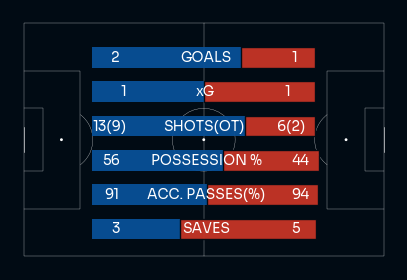

In [49]:
fig, ax = plt.subplots(figsize=(5, 5), facecolor=background)  # Use plt.subplots() instead of plt.figure()

match_stats_ws(ax, team1_facecolor, team2_facecolor, 56, 44,91,94,3,5,1,1)


## ShotMaps

### WhoScored

In [104]:
def shotMap_ws(ax,hteam,ateam,team1_facecolor,team2_facecolor):
    pitch = Pitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)

    mask1 = ((df['teamName'] == hteam)) & ((df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost'))
    mask2 = ((df['teamName'] == ateam)) & ((df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost'))

    home_shots_df = df[mask1]
    home_shots_df.reset_index(drop=True, inplace=True)
    h_missed = home_shots_df[home_shots_df['type'] == 'MissedShots']
    h_saved = home_shots_df[home_shots_df['type'] == 'SavedShot']
    h_post = home_shots_df[home_shots_df['type'] == 'ShotOnPost']
    h_goals = home_shots_df[home_shots_df['type'] == 'Goal']

    away_shots_df = df[mask2]
    away_shots_df.reset_index(drop=True, inplace=True)
    a_missed = away_shots_df[away_shots_df['type'] == 'MissedShots']
    a_saved = away_shots_df[away_shots_df['type'] == 'SavedShot']
    a_post = away_shots_df[away_shots_df['type'] == 'ShotOnPost']
    a_goals = away_shots_df[away_shots_df['type'] == 'Goal']

    h_missed['x'] = pitch.dim.right - h_missed.x
    h_saved['x'] = pitch.dim.right - h_saved.x
    h_post['x'] = pitch.dim.right - h_post.x
    h_goals['x'] = pitch.dim.right - h_goals.x

    pitch.scatter(h_missed.x,h_missed.y,marker='o', edgecolors=team1_facecolor, s=300, c=background,ax=ax)
    pitch.scatter(h_saved.x,h_saved.y,marker='o', edgecolors='white', s=300, c=team1_facecolor,zorder=4,ax=ax)
    pitch.scatter(h_post.x,h_post.y,marker='o', edgecolors='green', s=300, c=team1_facecolor,zorder=5,ax=ax)
    pitch.scatter(h_goals.x,h_goals.y,marker='football', edgecolors='white', s=500, c=team1_facecolor,ax=ax)

    pitch.scatter(a_missed.x,a_missed.y,marker='o', edgecolors=team2_facecolor, s=300, c=background,ax=ax)
    pitch.scatter(a_saved.x,a_saved.y,marker='o', edgecolors='white', s=300, c=team2_facecolor,zorder=4,ax=ax)
    pitch.scatter(a_post.x,a_post.y,marker='o', edgecolors='green', s=300, c=team2_facecolor,zorder=5,ax=ax)
    pitch.scatter(a_goals.x,a_goals.y,marker='football', edgecolors='white', s=500, c=team2_facecolor,ax=ax)
    return

In [118]:
def shotMap_ws(ax,team,team_color,xG,xGOT):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)

    mask = ((df['teamName'] == team)) & ((df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost'))
    
    shots_df = df[mask]
    shots_df.reset_index(drop=True, inplace=True)
    missed = shots_df[shots_df['type'] == 'MissedShots']
    saved = shots_df[shots_df['type'] == 'SavedShot']
    post = shots_df[shots_df['type'] == 'ShotOnPost']
    goals = shots_df[shots_df['type'] == 'Goal']
    #xG = round(shots_df['expectedGoals'].sum(),2)
    #xGOT = round(shots_df['expectedGoalsOnTarget'].sum(),2)

    pitch.scatter(missed.x,missed.y,marker='o', edgecolors=team_color, s=200, c=background,ax=ax)
    pitch.scatter(saved.x,saved.y,marker='o', edgecolors='white', s=200, c=team_color,zorder=4,ax=ax)
    pitch.scatter(post.x,post.y,marker='o', edgecolors='red', s=200, c=team_color,zorder=5,ax=ax)
    pitch.scatter(goals.x,goals.y,marker='football', edgecolors=background, s=500,zorder=6, c=team_color,ax=ax)

    
    ax.text(45,108, f"ShotMap", fontsize=20,color='white',fontproperties=font_prop)
    
    ax.text(65,70, f'Total Shots: {shots_df.shape[0]}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,65, f'Goals: {goals.shape[0]}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,60, f'Shots on Target: {saved.shape[0]}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,55, f'Shots off Target: {missed.shape[0]}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(18,60, f'xG: {xG}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(19,55, f'xGOT: {xGOT}', fontsize=12, ha='left', va='center',color='white',fontproperties=font_prop)
    return

### Understat

In [30]:
# Convert 'x' to integer and then to float for accurate calculations
home_shots_df['x'] = pd.to_numeric(home_shots_df['x'], errors='coerce')
home_shots_df['x'] = (home_shots_df['x'] / 100) * 105 * 100  # Convert to cm based on 105m length

# Convert 'y' similarly
home_shots_df['y'] = pd.to_numeric(home_shots_df['y'], errors='coerce')
home_shots_df['y'] = (home_shots_df['y'] / 100) * 68 * 100  # Convert to cm based on 68m width

# Convert 'x' to integer and then to float for accurate calculations
away_shots_df['x'] = pd.to_numeric(away_shots_df['x'], errors='coerce')
away_shots_df['x'] = (away_shots_df['x'] / 100) * 105 * 100  # Convert to cm based on 105m length

# Convert 'y' similarly
away_shots_df['y'] = pd.to_numeric(away_shots_df['y'], errors='coerce')
away_shots_df['y'] = (away_shots_df['y'] / 100) * 68 * 100  # Convert to cm based on 68m width

home_shots_df['expectedGoals'] = home_shots_df['xG']
away_shots_df['expectedGoals'] = away_shots_df['xG']

home_shots_df['expectedGoals'] = pd.to_numeric(home_shots_df['expectedGoals'], errors='coerce')
away_shots_df['expectedGoals'] = pd.to_numeric(away_shots_df['expectedGoals'], errors='coerce')

In [165]:
away_shots_df[away_shots_df['result']=='Goal']

,id,minute,result,x,y,xG,player,h_a,situation,shotType,player_assisted,lastAction,expectedGoals
7,619484,60,Goal,80.745002,48.144002,0.01894274540245533,Justin Kluivert,a,OpenPlay,RightFoot,Milos Kerkez,Pass,0.018943


In [168]:
away_shots_df[(away_shots_df.result == 'Goal') & (away_shots_df.shotType != 'Head')]

,id,minute,result,x,y,xG,player,h_a,situation,shotType,player_assisted,lastAction,expectedGoals
7,619484,60,Goal,80.745002,48.144002,0.01894274540245533,Justin Kluivert,a,OpenPlay,RightFoot,Milos Kerkez,Pass,0.018943


### Viz

In [31]:
def shotmap(team1,team2,team1_color,team2_color,home_shots_df,away_shots_df,ax):
    df_team1 = home_shots_df[(home_shots_df.result != 'Goal') & (home_shots_df.shotType != 'Head')].copy()
    df_team2 = away_shots_df[(away_shots_df.result != 'Goal') & (away_shots_df.shotType != 'Head')].copy()
    
    df_team1_goals = home_shots_df[(home_shots_df.result == 'Goal') & (home_shots_df.shotType != 'Head')].copy()
    df_team2_goals = away_shots_df[(away_shots_df.result == 'Goal') & (away_shots_df.shotType != 'Head')].copy()
    
    df_team1_headers_goals = home_shots_df[(home_shots_df.result == 'Goal') & (home_shots_df.shotType == 'Head')].copy()
    df_team2_headers_goals = away_shots_df[(away_shots_df.result == 'Goal') & (away_shots_df.shotType == 'Head')].copy()
    
    df_team1_own_goals = home_shots_df[(home_shots_df.result == 'OwnGoal')].copy()
    df_team2_own_goals = away_shots_df[(away_shots_df.result == 'OwnGoal')].copy()
    
    df_team1_headers = home_shots_df[(home_shots_df.result != 'Goal') & (home_shots_df.shotType == 'Head')].copy()
    df_team2_headers = away_shots_df[(away_shots_df.result != 'Goal') & (away_shots_df.shotType == 'Head')].copy()
    
    team1_xg = round(home_shots_df['expectedGoals'].astype(float).sum(),2)
    team2_xg = round(away_shots_df['expectedGoals'].astype(float).sum(),2)
    
    team1_goals = df_team1_goals.shape[0] + df_team2_own_goals.shape[0] + df_team1_headers_goals.shape[0]
    team2_goals = df_team2_goals.shape[0] + df_team1_own_goals.shape[0] + df_team2_headers_goals.shape[0]
    
    team1_shots = df_team1.shape[0] + df_team1_goals.shape[0] + df_team1_headers_goals.shape[0] + df_team1_headers.shape[0]
    team2_shots = df_team2.shape[0] + df_team2_goals.shape[0] + df_team2_headers_goals.shape[0] + df_team2_headers.shape[0]
    
    team1_shots_ot = df_team1[df_team1['result'] == 'SavedShot'].shape[0] + df_team1_headers[df_team1_headers['result'] == 'SavedShot'].shape[0] + df_team1_goals.shape[0]
    team2_shots_ot = df_team2[df_team2['result'] == 'SavedShot'].shape[0] + df_team2_headers[df_team2_headers['result'] == 'SavedShot'].shape[0] + df_team2_goals.shape[0]

    

    #fig, axs = pitch.grid(grid_height=0.9, title_height=0.04, axis=False,
    #                     endnote_height=0.03, title_space=0, endnote_space=0)

    #pitch = Pitch(pitch_type='custom',pitch_length = 105,pitch_width = 68, line_zorder=2
    #          ,pitch_color=background, line_color='white',linewidth=1)
    pitch = Pitch(pitch_type='uefa', line_zorder=1
              ,pitch_color=background, line_color='white',linewidth=1)
    pitch.draw(ax=ax)

    df_team1['x'] = pitch.dim.right - df_team1.x
    df_team1_goals['x'] = pitch.dim.right - df_team1_goals.x
    #df_team2_own_goals['x'] = pitch.dim.right - df_team2_goals.x
    df_team1_headers['x'] = pitch.dim.right - df_team1_goals.x
    df_team1_headers_goals['x'] = pitch.dim.right - df_team1_headers_goals.x
    
    df_team2['y'] = pitch.dim.top - df_team2.y
    #df_team2_goals['y'] = pitch.dim.top - df_team2_goals.y
    #df_team2_headers_goals['y'] = pitch.dim.top - df_team2_headers_goals.y

    #print(df_team1_goals)

    pitch.scatter(80,0.1,s=50,ec='white',color='grey',ax=ax,alpha=0.5,zorder=2)
    pitch.scatter(90,0.1,s=150,ec='white',color='grey',ax=ax,alpha=0.5,zorder=2)
    pitch.scatter(100,0.1,s=300,ec='white',color='grey',ax=ax,alpha=0.5,zorder=2)
    
    #pitch.scatter(2,2,s=100,edgecolors='white', c='grey',marker='football',ax=ax,alpha=0.5,zorder=2)
    #ax.text(6, 2, 'GOAL', color = 'white', ha='center', va='center',fontsize=12,fontproperties=font_prop,zorder=2)
    pitch.scatter(2,2,s=100,edgecolors='yellow', c=background,marker='o',ax=ax,alpha=0.8,zorder=2)
    ax.text(12, 2, 'Header', color = 'white', ha='center', va='center',fontsize=10,fontproperties=font_prop,zorder=2)
    
    sc_team1 = pitch.scatter(df_team1.x, df_team1.y, s=df_team1.expectedGoals * 400,
                             edgecolors=background, c=team1_facecolor, ax=ax,zorder=2)
    sc_team1_goals = pitch.scatter(df_team1_goals.x, df_team1_goals.y, s=df_team1_goals.expectedGoals * 500,
                             edgecolors='white', c=team1_facecolor,marker='football', ax=ax,zorder=2)
    sc_team1_headers = pitch.scatter(df_team1_headers.x, df_team1_headers.y, s=df_team1_headers.expectedGoals * 400,
                             edgecolors='yellow', c=team1_facecolor,marker='o', ax=ax,zorder=2)
    sc_team1_headers_goals = pitch.scatter(df_team1_headers_goals.x, df_team1_headers_goals.y, s=df_team1_headers_goals.expectedGoals * 500,
                             edgecolors='yellow', c=team1_facecolor,marker='football', ax=ax,zorder=2)
    sc_team2 = pitch.scatter(df_team2.x, df_team2.y, s=df_team2.expectedGoals * 400,
                             edgecolors=background, c=team2_facecolor, ax=ax,zorder=2)
    sc_team2_goals = pitch.scatter(df_team2_goals.x, df_team2_goals.y, s=df_team2_goals.expectedGoals * 1000,
                             edgecolors='white', c=team2_facecolor,marker='football', ax=ax,zorder=2)
    sc_team2_headers = pitch.scatter(df_team2_headers.x, df_team2_headers.y, s=df_team2_headers.expectedGoals * 400,
                             edgecolors='yellow', c=team2_facecolor,marker='o', ax=ax,zorder=2)
    sc_team2_headers_goals = pitch.scatter(df_team2_headers_goals.x, df_team2_headers_goals.y, s=df_team2_headers_goals.expectedGoals * 500,
                             edgecolors='yellow', c=team2_facecolor,marker='football', ax=ax,zorder=2)
    
    sc_team1_own_goals = pitch.scatter(df_team1_own_goals.x, df_team1_own_goals.y, s=500,
                             edgecolors='orange', c=team2_facecolor,marker='football', ax=ax,zorder=2)
    
    sc_team2_own_goals = pitch.scatter(df_team2_own_goals.x, df_team2_own_goals.y, s=500,
                             edgecolors='orange', c=team1_facecolor,marker='football', ax=ax,zorder=2)
    
    fig.set_facecolor(background)
    ax.text(40,75,"ShotMap", color='white', fontsize=20,fontproperties=font_prop)
    
    
    endnote_text2 = "Increasing xG ->"
    ax.annotate(endnote_text2, xy=(0.85, 0.01), xycoords='axes fraction',ha='center', va='center', fontsize=10, color='white')

In [32]:
def shotmap_v2(ax,team,team_color,shots_df):
    df_team = shots_df[(shots_df.result != 'Goal') & (shots_df.shotType != 'Head')].copy()
    
    df_team_goals = shots_df[(shots_df.result == 'Goal') & (shots_df.shotType != 'Head')].copy()
    
    df_team_headers_goals = shots_df[(shots_df.result == 'Goal') & (shots_df.shotType == 'Head')].copy()
    
    df_team_own_goals = shots_df[(shots_df.result == 'OwnGoal')].copy()
    
    df_team_headers = shots_df[(shots_df.result != 'Goal') & (shots_df.shotType == 'Head')].copy()
    
    team_xg = round(shots_df['expectedGoals'].astype(float).sum(),2)
    
    
    pitch = VerticalPitch(pitch_type='uefa',half=True, line_zorder=1
              ,pitch_color=background, line_color='white',linewidth=1)
    pitch.draw(ax=ax)
    
    #pitch.scatter(2,2,s=100,edgecolors='white', c='grey',marker='football',ax=ax,alpha=0.5,zorder=2)
    #ax.text(6, 2, 'GOAL', color = 'white', ha='center', va='center',fontsize=12,fontproperties=font_prop,zorder=2)
    pitch.scatter(55,20,s=100,edgecolors='yellow', c=background,marker='o',ax=ax,zorder=2)
    ax.text(10, 55, 'Header', color = 'white', ha='center', va='center',fontsize=10,fontproperties=font_prop,zorder=2)
    
    sc_team = pitch.scatter(df_team.x, df_team.y, s=df_team.expectedGoals * 400,
                             edgecolors=background, c=team_color, ax=ax,zorder=2)
    sc_team_goals = pitch.scatter(df_team_goals.x, df_team_goals.y, s=df_team_goals.expectedGoals * 700,
                             edgecolors='white', c=team_color,marker='football', ax=ax,zorder=2)
    sc_team_headers = pitch.scatter(df_team_headers.x, df_team_headers.y, s=df_team_headers.expectedGoals * 400,
                             edgecolors='yellow', c=team_color,marker='o', ax=ax,zorder=2)
    sc_team_headers_goals = pitch.scatter(df_team_headers_goals.x, df_team_headers_goals.y, s=df_team_headers_goals.expectedGoals * 700,
                             edgecolors='yellow', c=team_color,marker='football', ax=ax,zorder=2)
    sc_team_own_goals = pitch.scatter(df_team_own_goals.x, df_team_own_goals.y, s=500,
                             edgecolors='orange', c=team_color,marker='football', ax=ax,zorder=2)

    
    fig.set_facecolor(background)
    ax.text(45,110,"ShotMap", color='white', fontsize=20,fontproperties=font_prop)

## xG Flow

In [52]:
away_shots_df.head()

,id,minute,result,x,y,xG,player,h_a,situation,shotType,player_assisted,lastAction
0,629582,0,ShotOnPost,0.8769999694824219,0.6170000076293946,0.3038172423839569,Marcus Rashford,a,OpenPlay,LeftFoot,Youri Tielemans,Pass
1,629584,17,Goal,0.885,0.5,0.7611688375473022,Marcus Rashford,a,Penalty,RightFoot,None,Standard
2,629587,29,BlockedShot,0.8859999847412109,0.519000015258789,0.10448994487524033,Ezri Konsa Ngoyo,a,OpenPlay,RightFoot,Pau Torres,BallTouch
3,629590,38,SavedShot,0.924000015258789,0.65,0.29006728529930115,Marcus Rashford,a,OpenPlay,RightFoot,Lucas Digne,Chipped
4,629591,43,MissedShots,0.9480000305175781,0.5029999923706054,0.07971290498971939,Amadou Onana,a,FromCorner,Head,Marcus Rashford,Aerial


In [49]:
def xgFlow(ax,home_shots_df,away_shots_df,team1,team2,team1_facecolor,team2_facecolor):
    dfhome_xG = home_shots_df[['player','minute','xG','result','situation']]
    dfaway_xG = away_shots_df[['player','minute','xG','result','situation']]
    #df_xG['teamName'] = df_xG.apply(lambda x: hometeam if x['teamId'] == team2Id else (awayteam if x['teamId'] == team1Id else None), axis=1)
    
    dfhome_xG['teamName'] = team1
    dfaway_xG['teamName'] = team2
    
    df_xG = pd.concat([dfhome_xG, dfaway_xG], ignore_index=True)
    
    df_xG['cumulative_xG'] = df_xG.groupby('teamName')['xG'].sum()
    
    df_xG['minute'] = pd.to_numeric(df_xG['minute'], errors='coerce')
    
    df_xG['half'] = df_xG['minute'].apply(lambda x: 1 if x <= 45 else 2)

    ax.set_facecolor(background)
    
    for team in df_xG['teamName'].unique():
        
        team_df = df_xG[df_xG['teamName'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({'teamName': team, 'minute': 0, 'xG': 0, 'result': 'Goal', 'cumulative_xG': 0, 'half': 1},
                                          index=[0]), team_df])
        
        # Also add a row at the beginning of the second half to make the lines start where the first half ended
        team_df = pd.concat([team_df[team_df['half'] == 1], pd.DataFrame({'teamName': team, 'minute': 45, 'xG': 0, 'result': 'Goal',
                                                                          'cumulative_xG': team_df[team_df['half'] == 1]['cumulative_xG'].iloc[-1],
                                                                          'half': 2}, index=[0]), team_df[team_df['half'] == 2]])
    
        for half in team_df['half'].unique():
            half_df = team_df[team_df['half'] == half]
            ax.plot(
                half_df['minute'], 
                half_df['cumulative_xG'], 
                label=team, 
                drawstyle='steps-post',
                c=team2_facecolor if team == team2 else team1_facecolor,
                linewidth=2
            )   
            
    
    # We Can add a scatter plot to show the goals
    for team in df_xG['teamName'].unique():
        team_df = df_xG[(df_xG['teamName'] == team) & (df_xG['result'] == 'Goal')].to_dict(orient='records')
        for x in team_df:
            ax.scatter(
                x['minute'], 
                x['cumulative_xG'], 
                c=team2_facecolor if team == team2 else team1_facecolor,
                edgecolor='white',
                s=300,
                marker='*',
                # We want the goals to be on top of the lines
                zorder=5
            )
            
            # add a label to the goals for the player who scored
            ax.text(
                x['minute']+1, 
                x['cumulative_xG'] + .2, 
                x['player'].split()[-1], 
                ha='center', 
                va='center',
                c='white',
                fontfamily='monospace', 
                fontsize=12,
                fontproperties=font_prop,
                zorder=10
            )
            
    # Let's label the x axis with first and second half
    ax.set_xticks([0, 45, 90])
    ax.set_xticklabels(['0\'', '45\'', '90\''])
    
    # Lets add the actual words "First Half" and "Second Half" to the plot under the x axis
    #ax.text(22.5, -.15, 'First Half', ha='center', fontfamily='monospace',fontproperties=font_prop, fontsize=20,color='white')
    #ax.text(67.5, -.15, 'Second Half', ha='center', fontfamily='monospace',fontproperties=font_prop, fontsize=20,color='white')
    #ax.text(107.5, -.25, 'Extra Time', ha='center', fontfamily='monospace', fontsize=20,color='white')

    #ax.text(45, 2, 'xG Flow', ha='center',fontproperties=font_prop, fontsize=20,color='white')
    
    # Let's label the y axis with the cumulative xG
    ax.set_ylabel('Cumulative xG', fontfamily='monospace',fontproperties=font_prop, fontsize=10,color='white')
    
    # Let's get rid of the right and top spines
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    
    #ax.tick_params(axis='x', colors='white', labelsize=10)
    #ax.tick_params(axis='y', colors='white', labelsize=10)
    
    ax.axvline(x=45, color='white', linestyle='--', linewidth=0.5,alpha=0.5)

C:\Users\acer\AppData\Local\Temp\ipykernel_12132\196163166.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhome_xG['teamName'] = team1
C:\Users\acer\AppData\Local\Temp\ipykernel_12132\196163166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfaway_xG['teamName'] = team2
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

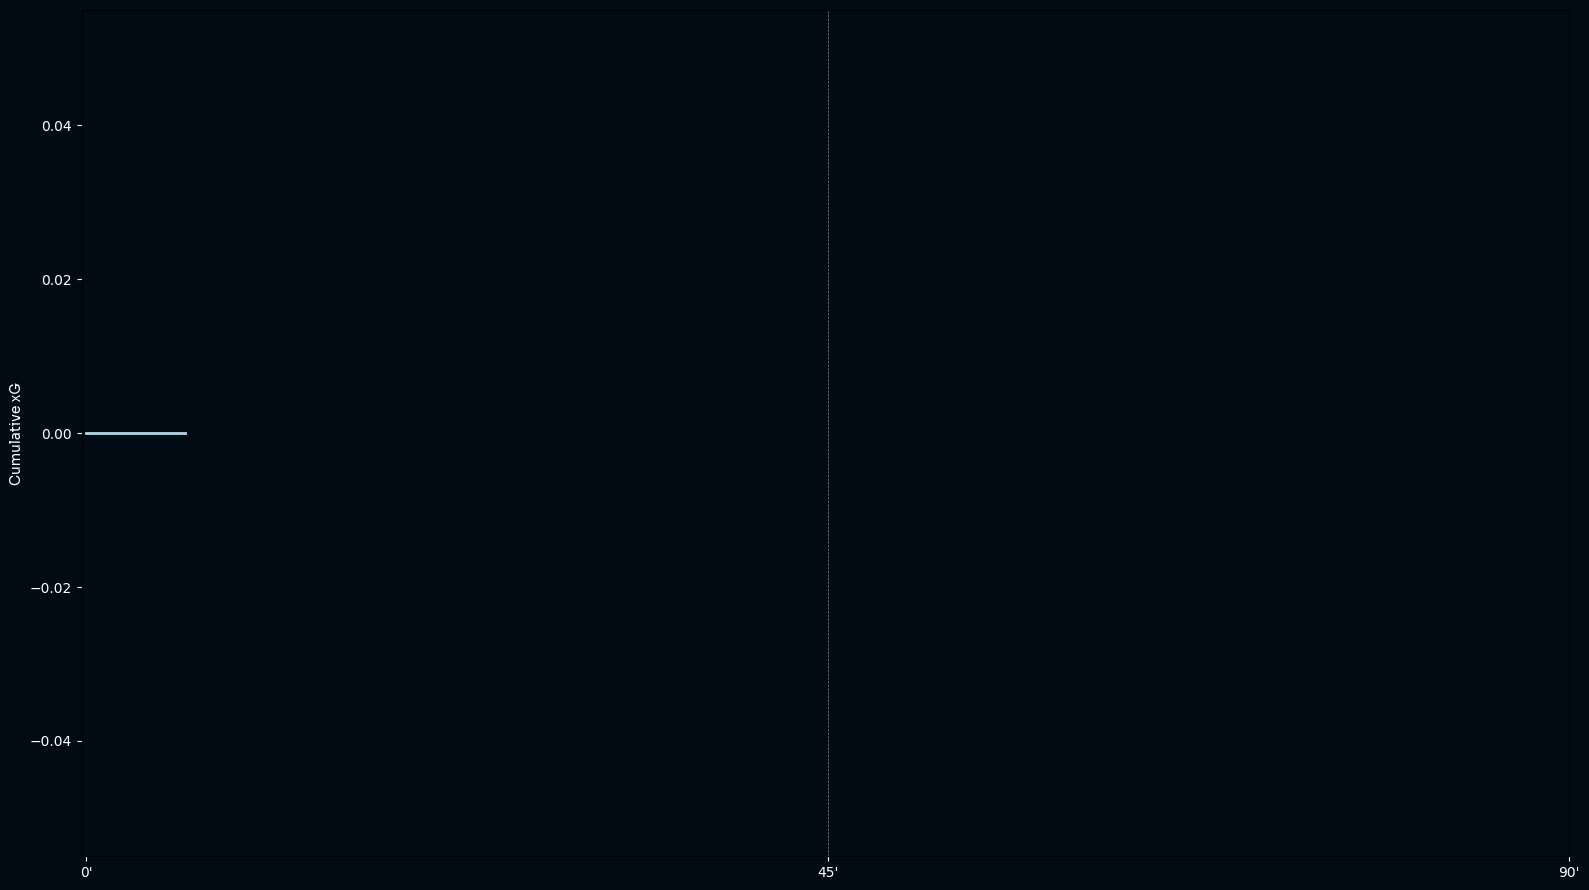

In [50]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

fig.set_facecolor(background)
ax.set_facecolor(background)

hteam = 'Manchester City'
ateam = 'Aston Villa'

xgFlow(ax,home_shots_df,away_shots_df,hteam,ateam,'lightblue','#670e36')
plt.tight_layout()

#plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/City.png',dpi=500,bbox_inches = 'tight',facecolor=background)


## PassingNetworks

In [5]:
df['teamName'].unique()

array(['Aston Villa', 'Man City'], dtype=object)

In [11]:
hteam = 'Man City'
ateam = 'Aston Villa'

In [12]:
import matplotlib.patheffects as path_effects
from matplotlib.colors import to_rgba

def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY","xT", "teamName", "playerId", "receiver", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes

passes_df = get_passes_df(df)
path_eff = [path_effects.Stroke(linewidth=3, foreground=background), path_effects.Normal()]

def passing_stats(teamName, df):
    dfpass = df[(df['teamName'] == teamName) & (df['type'] == 'Pass')]

    total_passes = dfpass.shape[0]
    acc_pass = dfpass[dfpass['outcomeType'] == 'Successful']
    through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Lng_ball = dfpass[(dfpass['qualifiers'].str.contains('Longball')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    Crosses = dfpass[(dfpass['qualifiers'].str.contains('Cross')) & (~dfpass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX'] >= 88.5) & (acc_pass['endY'] >= 13.6) & (acc_pass['endY'] <= 54.4) & 
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]

    return total_passes, acc_pass.shape[0], Lng_ball.shape[0], Crosses.shape[0], pen_box.shape[0]

def get_passes_between_df(teamName, passes_df, players_df):
    passes_df = passes_df[(passes_df["teamName"] == teamName)]
    # df = pd.DataFrame(events_dict)
    dfteam = df[(df['teamName'] == teamName) & (~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card'))]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    average_locs_and_count_df['name'] = average_locs_and_count_df['name'].apply(unidecode)
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['index', 'playerId', 'receiver', 'teamName']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).index.count().reset_index()
    passes_between_df.rename({'index': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

# home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(hteam, passes_df, players_df)
# away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(ateam, passes_df, players_df)

C:\Users\acer\AppData\Local\Temp\ipykernel_12132\608997767.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "receiver"] = df["playerId"].shift(-1)


In [28]:
def pass_network_visualization(ax,df, passes_between_df, average_locs_and_count_df, col, teamName,MAX_LINE_WIDTH, flipped=False):
    MAX_MARKER_SIZE = 3000
    line_color='white'
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max()) * MAX_LINE_WIDTH
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.55
    MAX_TRANSPARENCY = 0.95
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=1)
    pitch.draw(ax=ax)
    ax.set_aspect('equal')
    
    if flipped==True:
        ax.invert_xaxis()
        ax.invert_yaxis()
        #ax.text(78,-7,"Passing Network", color='white', fontsize=20,fontproperties=font_prop)
        #pitch.annotate(f'CI - {round(centralization_index,3)}', xy=(9, 65), c=col, ha='center', va='center', size=15, ax=ax)
      
    else:
        ax.text(27,75,"Passing Network", color='white', fontsize=20,fontproperties=font_prop)
        #pitch.annotate(f'CI - {round(centralization_index,3)}', xy=(95, 4), c=col, ha='center', va='center', size=15, ax=ax)
    #ax.set_xlim(-0.5, 105.5)
    #ax.set_ylim(-0.5, 68.5)
    
    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color='white', zorder=2,alpha=0.5, ax=ax)
    '''
    for _, row in passes_between_df.iterrows():
        pitch.lines(
            row.pass_avg_x, row.pass_avg_y, row.pass_avg_x_end, row.pass_avg_y_end,
            lw=row.width, color='white', comet=True, zorder=1, alpha=0.5, ax=ax
        )
    '''

    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=row['marker_size'], marker='o', color=background, edgecolor=col,
                                   linewidth=2, alpha=1,zorder=2, ax=ax)
      #else:
        #pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=900, marker='s', color=background, edgecolor=line_color, linewidth=2, alpha=0.7, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        if row['isFirstEleven'] == True:
            player_initials = row["shirtNo"]
            pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c='white', ha='center', va='center', size=15,zorder=2, ax=ax)

    dfteam = df[df['teamName'] == teamName]
    df_xT = dfteam[((dfteam['type'] == 'Pass') | (dfteam['type'] == 'Carry')) & (dfteam['xT'] > 0)]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', [background, col])  # White to team color
    # Plot heatmap
    #pitch.kdeplot(
    #    x=df_xT['x'], y=df_xT['y'],
    #    weights=df_xT['xT'],  # Weight by xT values
    #    fill=True, cmap=cmap, alpha=0.3, levels=100,zorder=1, ax=ax
    #)
    
    bin_statistic = pitch.bin_statistic(df_xT.x, df_xT.y, statistic='count', bins=(20, 20))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=cmap, edgecolors=background,alpha=0.5,zorder=1)
    

    
    return

In [29]:
df.columns

Index(['index', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal_x', 'cardType_x',
       'isOwnGoal_x', 'cumulative_mins', 'isGoal_y', 'cardType_y',
       'isOwnGoal_y', 'x1_bin_xT', 'y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT',
       'start_zone_value_xT', 'end_zone_value_xT', 'xT', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'prog_pass', 'prog_carry', 'pass_or_carry_angle', 'shortName',
       'Pass Type', 'Carry Type', 'IsCorner'],
      dtype='object')

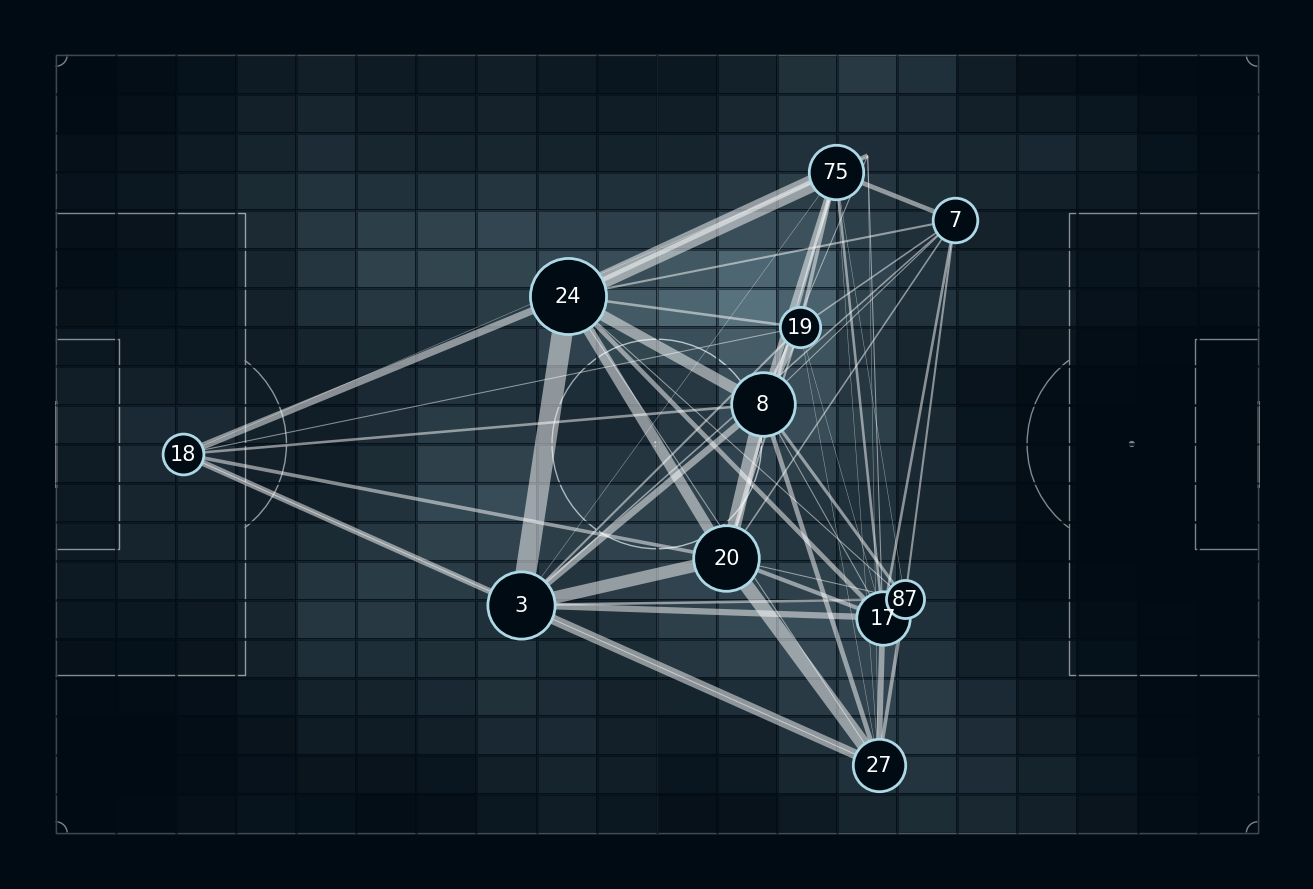

In [26]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

fig.set_facecolor(background)
ax.set_facecolor(background)

pass_network_visualization(ax,df, home_passes_between_df, home_average_locs_and_count_df, 'lightblue', hteam,15, flipped=False)
plt.tight_layout()

plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/City.png',dpi=500,bbox_inches = 'tight',facecolor=background)


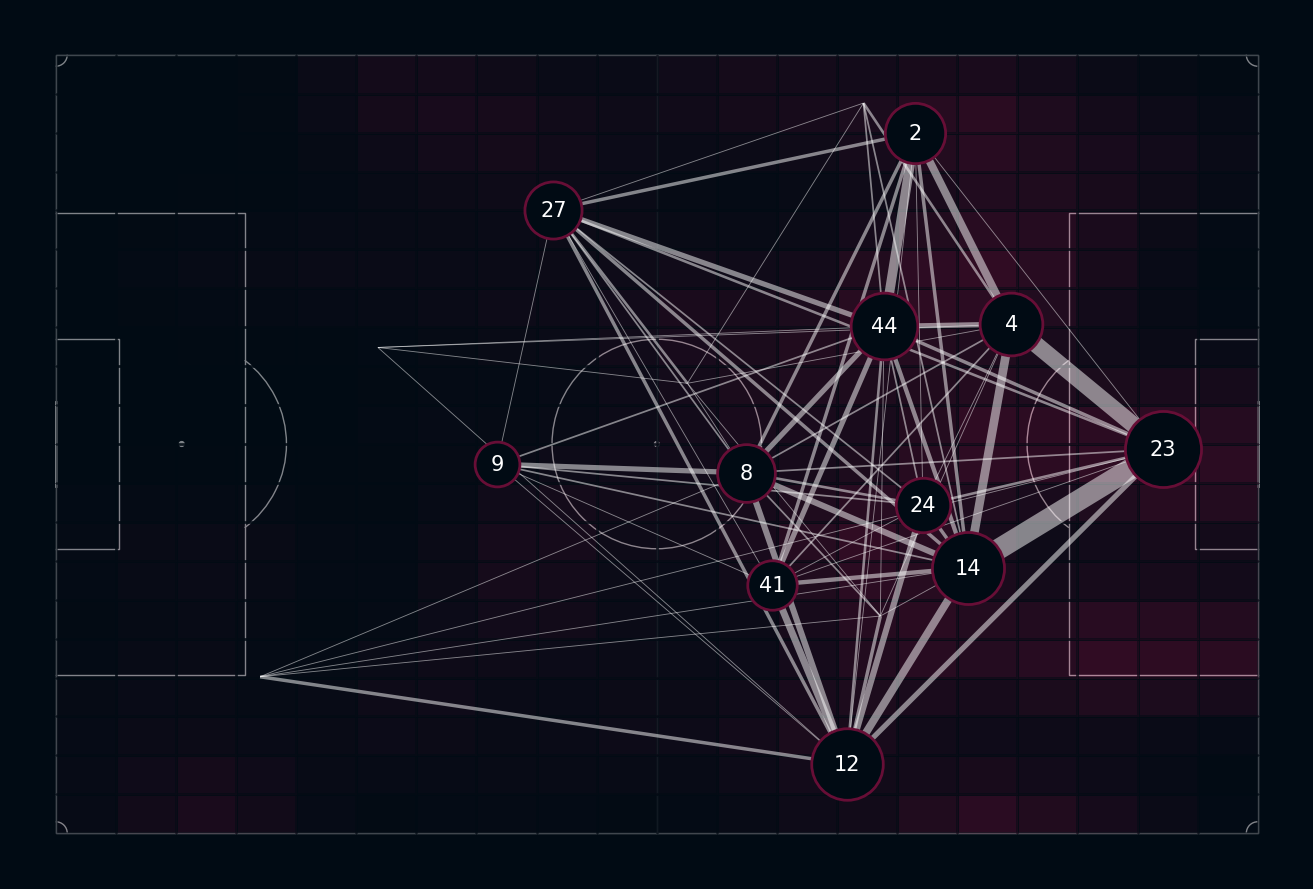

In [30]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

fig.set_facecolor(background)
ax.set_facecolor(background)

pass_network_visualization(ax,df, away_passes_between_df, away_average_locs_and_count_df, '#670e36', ateam,15, flipped=True)
plt.tight_layout()

#plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/Villa.png',dpi=500,bbox_inches = 'tight',facecolor=background)


## Dominated Zones

In [31]:
from matplotlib.colors import LinearSegmentedColormap
from highlight_text import ax_text, fig_text
def plot_congestion(ax,df,team1_name,team2_name,team1_facecolor,team2_facecolor):
    # Comparing open play touches of both teams in each zones of the pitch, if more than 55% touches for a team it will be coloured of that team, otherwise gray to represent contested
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [team2_facecolor, 'gray', team1_facecolor], N=20)
    df1 = df[(df['teamName']==team1_name) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2 = df[(df['teamName']==team2_name) & (df['isTouch']==1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df2['x'] = 105-df2['x']
    df2['y'] =  68-df2['y']
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=1, line_zorder=4)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5,68.5)
    #ax.set_xlim(-0.5,105.5)

    bin_statistic1 = pitch.bin_statistic(df1.x, df1.y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(df2.x, df2.y, bins=(6,5), statistic='count', normalize=False)

    # Assuming 'cx' and 'cy' are as follows:
    cx = np.array([[ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25],
               [ 8.75, 26.25, 43.75, 61.25, 78.75, 96.25]])

    cy = np.array([[61.2, 61.2, 61.2, 61.2, 61.2, 61.2],
               [47.6, 47.6, 47.6, 47.6, 47.6, 47.6],
               [34.0, 34.0, 34.0, 34.0, 34.0, 34.0],
               [20.4, 20.4, 20.4, 20.4, 20.4, 20.4],
               [ 6.8,  6.8,  6.8,  6.8,  6.8,  6.8]])

    # Flatten the arrays
    cx_flat = cx.flatten()
    cy_flat = cy.flatten()

    # Create a DataFrame
    df_cong = pd.DataFrame({'cx': cx_flat, 'cy': cy_flat})

    hd_values = []
    # Loop through the 2D arrays
    for i in range(bin_statistic1['statistic'].shape[0]):
        for j in range(bin_statistic1['statistic'].shape[1]):
            stat1 = bin_statistic1['statistic'][i, j]
            stat2 = bin_statistic2['statistic'][i, j]

            if (stat1 / (stat1 + stat2)) > 0.55:
                hd_values.append(1)
            elif (stat1 / (stat1 + stat2)) < 0.45:
                hd_values.append(0)
            else:
                hd_values.append(0.5)

    df_cong['hd']=hd_values
    bin_stat = pitch.bin_statistic(df_cong.cx, df_cong.cy, bins=(6,5), values=df_cong['hd'], statistic='sum', normalize=False)
    pitch.heatmap(bin_stat, ax=ax, cmap=pcmap, edgecolors='#000000', lw=0, zorder=3, alpha=0.85)

    
    ax.text(0,  -3, 'Attacking Direction--->', color=team1_facecolor, fontsize=10, ha='left', va='center',font_properties=font_prop)
    ax.text(105,-3, '<---Attacking Direction', color=team2_facecolor, fontsize=10, ha='right', va='center',font_properties=font_prop)

    ax.vlines(1*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(2*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(3*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(4*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)
    ax.vlines(5*(105/6), ymin=0, ymax=68, color=background, lw=2, ls='--', zorder=5)

    ax.hlines(1*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(2*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(3*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)
    ax.hlines(4*(68/5), xmin=0, xmax=105, color=background, lw=2, ls='--', zorder=5)

    ## Duels
    d1 = df[(df['teamName']==team1_name) & (df['outcomeType'] == 'Successful') & ((df['type'] == 'Tackle') | (df['type'] == 'BallRecovery') | (df['type'] == 'Challenge') | (df['type'] == 'Aerial'))]
    d2 = df[(df['teamName']==team2_name) & (df['outcomeType'] == 'Successful') & ((df['type'] == 'Tackle') | (df['type'] == 'BallRecovery') | (df['type'] == 'Challenge') | (df['type'] == 'Aerial'))]

    d2['x'] = 105-d2['x']
    d2['y'] =  68-d2['y']
    bin_statistic1 = pitch.bin_statistic(d1.x, d1.y, bins=(6,5), statistic='count', normalize=False)
    bin_statistic2 = pitch.bin_statistic(d2.x, d2.y, bins=(6,5), statistic='count', normalize=False)
    pitch.heatmap(bin_statistic1, ax=ax, cmap=pcmap, edgecolors='#f8f8f8')
    pitch.heatmap(bin_statistic2, ax=ax, cmap=pcmap, edgecolors='#f8f8f8')

    labels1 = pitch.label_heatmap(bin_statistic1, color=team1_facecolor, fontsize=12, ax=ax, ha='left', va='center', str_format='{:.0f}', path_effects=path_eff,zorder=5)
    #labels3 = pitch.text('-', color='gray', fontsize=20, ax=ax, ha='left', va='top',zorder=5)
    labels2 = pitch.label_heatmap(bin_statistic2, color=team2_facecolor, fontsize=12, ax=ax, ha='right', va='center', str_format='{:.0f}', path_effects=path_eff,zorder=5)

    ax.text(53,  77, 'Duels Won', color='white', fontsize=20, ha='center', va='center',font_properties=font_prop)
    return



C:\Users\acer\AppData\Local\Temp\ipykernel_12132\2751274056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\acer\AppData\Local\Temp\ipykernel_12132\2751274056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']
C:\Users\acer\AppData\Local\Temp\ipykernel_12132\2751274056.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

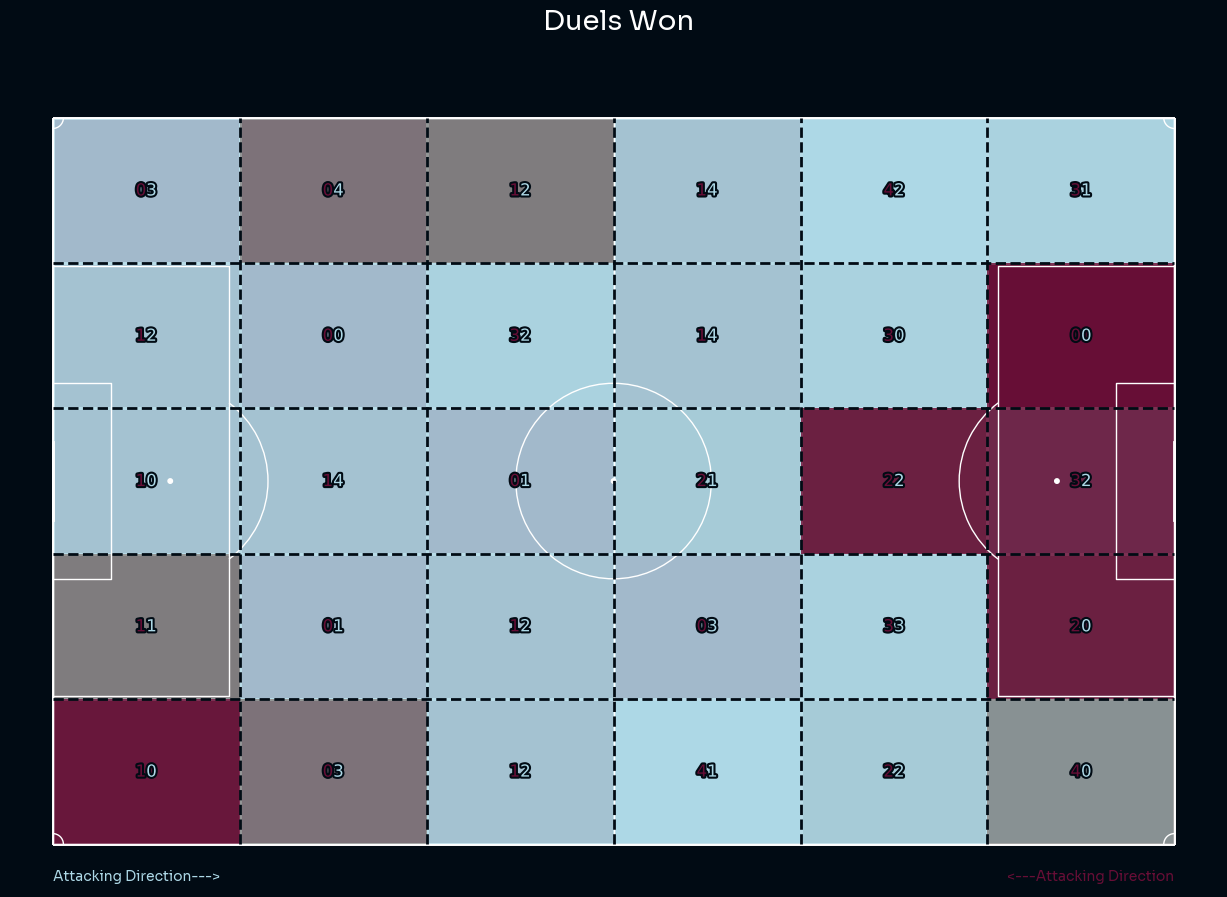

In [32]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

fig.set_facecolor(background)
ax.set_facecolor(background)

plot_congestion(ax,df,hteam,ateam,'lightblue','#670e36')
plt.tight_layout()

#plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/Plots/City.png',dpi=500,bbox_inches = 'tight',facecolor=background)


## Defensive Actions

In [111]:
from matplotlib.colors import to_rgba
def get_defensive_action_df(events_dict):
    # filter only defensive actions
    defensive_actions_ids = df.index[(df['type'] == 'Aerial') & (df['qualifiers'].str.contains('Defensive')) |
                                     (df['type'] == 'BallRecovery') |
                                     (df['type'] == 'BlockedPass') |
                                     (df['type'] == 'Challenge') |
                                     (df['type'] == 'Clearance') |
                                     (df['type'] == 'Error') |
                                     (df['type'] == 'Foul') |
                                     (df['type'] == 'Interception') |
                                     (df['type'] == 'Tackle')]
    df_defensive_actions = df.loc[defensive_actions_ids, ["index", "x", "y", "teamName", "playerId", "type", "outcomeType","name"]]

    return df_defensive_actions

defensive_actions_df = get_defensive_action_df(events_dict)

def calculate_event_types(dataframe, event_types=None):
    # Group by 'teamName' and 'type', then count occurrences
    event_counts = dataframe.groupby(['teamName', 'type']).size().reset_index(name='count')
    
    # If event_types is provided, filter the event_counts DataFrame
    if event_types is not None:
        event_counts = event_counts[event_counts['type'].isin(event_types)]
    
    # Create a dictionary to hold the results
    results = {}
    
    # Populate the dictionary with team names and their event types and counts
    for team in event_counts['teamName'].unique():
        team_data = event_counts[event_counts['teamName'] == team]
        results[team] = {
            'types': team_data['type'].tolist(),
            'counts': team_data['count'].tolist()
        }
    
    return results

desired_event_types = ['Aerial', 'BallRecovery','Challenge','Interception', 'Tackle']
result = calculate_event_types(df, event_types=desired_event_types)
team1_def_stats = []
team2_def_stats = []
for team, data in result.items():
    if team == hteam:
        team1_def_stats.append(data['counts'])
    else:
        team2_def_stats.append(data['counts'])
team1_def_stats = [item for sublist in team1_def_stats for item in sublist]
team2_def_stats = [item for sublist in team2_def_stats for item in sublist]

def get_da_count_df(team_name, defensive_actions_df, players_df):
    defensive_actions_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    # add column with first eleven players only
    defensive_actions_df = defensive_actions_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate mean positions for players
    average_locs_and_count_df = (defensive_actions_df.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    return  average_locs_and_count_df

defensive_home_average_locs_and_count_df = get_da_count_df(hteam, defensive_actions_df, players_df)
defensive_away_average_locs_and_count_df = get_da_count_df(ateam, defensive_actions_df, players_df)
defensive_home_average_locs_and_count_df = defensive_home_average_locs_and_count_df[defensive_home_average_locs_and_count_df['position'] != 'GK']
defensive_away_average_locs_and_count_df = defensive_away_average_locs_and_count_df[defensive_away_average_locs_and_count_df['position'] != 'GK']

def defensive_block(ax, average_locs_and_count_df, team_name, col,flipped=False):
    defensive_actions_team_df = defensive_actions_df[defensive_actions_df["teamName"] == team_name]
    pitch = Pitch(pitch_type='uefa', pitch_color=background, line_color='white', linewidth=1, line_zorder=2, corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_facecolor(background)
    if flipped==True:
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.text(78,-7,"Defensive Actions", color='white', fontsize=20,fontproperties=font_prop)
        #pitch.annotate(f'CI - {round(centralization_index,3)}', xy=(9, 65), c=col, ha='center', va='center', size=15, ax=ax)
      
    else:
        ax.text(27,75,"Defensive Actions", color='white', fontsize=20,fontproperties=font_prop)
    #ax.set_xlim(-0.5, 105.5)
    #ax.set_ylim(-0.5, 68.5)
    color = np.array(to_rgba(col))
    flamingo_cmap = LinearSegmentedColormap.from_list("Flamingo - 100 colors", [background, col], N=500)
    kde = pitch.kdeplot(defensive_actions_team_df.x, defensive_actions_team_df.y, ax=ax, fill=True, levels=5000,alpha=0.7, thresh=0.02, cut=4, cmap=flamingo_cmap)

    average_locs_and_count_df = average_locs_and_count_df.reset_index(drop=True)
    for index,row in defensive_actions_team_df.iterrows():
        if row['type'] == 'Aerial':
            pitch.scatter(row.x, row.y, s=10, marker='x', color='white', alpha=0.8, ax=ax)
        elif row['type'] == 'BallRecovery':
            pitch.scatter(row.x, row.y, s=10, marker='o', color='white', alpha=0.8, ax=ax)
        elif row['type'] == 'Challenge':
            pitch.scatter(row.x, row.y, s=10, marker='^', color='white', alpha=0.8, ax=ax)
        elif row['type'] == 'Interception':
            pitch.scatter(row.x, row.y, s=10, marker='+', color='white', alpha=0.8, ax=ax)
        elif row['type'] == 'Tackle':
            pitch.scatter(row.x, row.y, s=10, marker='*', color='white', alpha=0.8, ax=ax)
        else:
            pitch.scatter(row.x, row.y, s=10, marker='.', color='white', alpha=0.5, ax=ax)

## Momemtum Chart

In [5]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def xT_momemtum(ax,df,team1_name,team2_name,team1_facecolor,team2_facecolor):
    xT_data = df[((df['type'] == 'Pass') | (df['type'] == 'Carry')) & (df['outcomeType'] == 'Successful')]
    xT_data = xT_data[['xT', 'minute', 'second', 'teamName', 'type']]
    xT_data['xT_clipped'] = np.clip(xT_data['xT'], 0, 0.1)

    max_xT_per_minute = xT_data.groupby(['teamName', 'minute'])['xT_clipped'].max().reset_index()

    minutes = sorted(xT_data['minute'].unique())
    weighted_xT_sum = {
        team1_name: [],
        team2_name: []
    }
    momentum = []
    
    window_size = 3
    decay_rate = 0.1
    
    
    for current_minute in minutes:
        for team in weighted_xT_sum.keys():
            
            recent_xT_values = max_xT_per_minute[
                                                (max_xT_per_minute['teamName'] == team) & 
                                                (max_xT_per_minute['minute'] <= current_minute) & 
                                                (max_xT_per_minute['minute'] > current_minute - window_size)
                                            ]
            
            weights = np.exp(-decay_rate * (current_minute - recent_xT_values['minute'].values))
            weighted_sum = np.sum(weights * recent_xT_values['xT_clipped'].values)
            weighted_xT_sum[team].append(weighted_sum)
    
        momentum.append(weighted_xT_sum[team1_name][-1] - weighted_xT_sum[team2_name][-1])
    
    momentum_df = pd.DataFrame({
        'minute': minutes,
        'momentum': momentum
    })

    ax.set_facecolor(background)

    ax.tick_params(axis='x', colors='white')
    ax.margins(x=0)
    ax.set_xticks([0,15,30,45,60,75,90])
    
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax.set_ylim(-0.15, 0.2)
    
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
    momentum_df['smoothed_momentum'] = gaussian_filter1d(momentum_df['momentum'], sigma=0.2)
    ax.plot(momentum_df['minute'], momentum_df['smoothed_momentum'], color='white')
    
    ax.axhline(0, color='white', linestyle='--', linewidth=0.5)
    ax.fill_between(momentum_df['minute'], momentum_df['smoothed_momentum'], where=(momentum_df['smoothed_momentum'] > 0), color=team1_facecolor, alpha=0.9, interpolate=True)
    ax.fill_between(momentum_df['minute'], momentum_df['smoothed_momentum'], where=(momentum_df['smoothed_momentum'] < 0), color=team2_facecolor, alpha=0.9, interpolate=True) 
    
    
    #scores = df[df['shot_outcome'] == 'Goal'].groupby('team')['shot_outcome'].count().reindex(set(df['team']), fill_value=0)
    #ax.set_xlabel('Minute', color='white', fontsize=15, fontweight='bold', fontproperties=font_prop)
    ax.set_ylabel('Momentum', color='white', fontsize=10, fontweight='bold', fontproperties=font_prop)
    ax.text(26,0.23,f'Momentum Flow', color='white', fontsize=20, fontproperties=font_prop)
    
    #home_team_text = ax.text(9, 0.1, team1_name, fontsize=15, ha='center', fontproperties=font_prop, fontweight='bold', color='white')
    #home_team_text.set_bbox(dict(facecolor=team1_facecolor, alpha=0.5, edgecolor='white', boxstyle='round'))
    #away_team_text = ax.text(7, -0.084, team2_name, fontsize=15, ha='center', fontproperties=font_prop, fontweight='bold', color='white')
    #away_team_text.set_bbox(dict(facecolor=team2_facecolor, alpha=0.5, edgecolor='white', boxstyle='round'))
    
    
    goals = df[df['type']=='Goal'][['minute', 'teamName','isOwnGoal_x']]
    goals.loc[(goals['teamName'] == team1_name) & (goals['isOwnGoal_x'] == True), 'teamName'] = team2_name
    goals.loc[(goals['teamName'] == team2_name) & (goals['isOwnGoal_x'] == True), 'teamName'] = team1_name
    for _, row in goals.iterrows():
        ymin, ymax = (0.4, 0.85) if row['teamName'] == team1_name else (0.08, 0.43)
        ax.axvline(row['minute'], color='white', linestyle='--', linewidth=1.5, alpha=0.5, ymin=ymin, ymax=ymax)
        ax.scatter(row['minute'], (1 if row['teamName'] == team1_name else -0.85)*0.15, color='white', s=100, zorder=10, alpha=0.9)
        ax.text(row['minute'], (1.2 if row['teamName'] == team1_name else -1)*0.14, 'G', fontsize=12, ha='center', va='center', fontproperties=font_prop, color=team1_facecolor if row['teamName'] == team1_name else team2_facecolor)

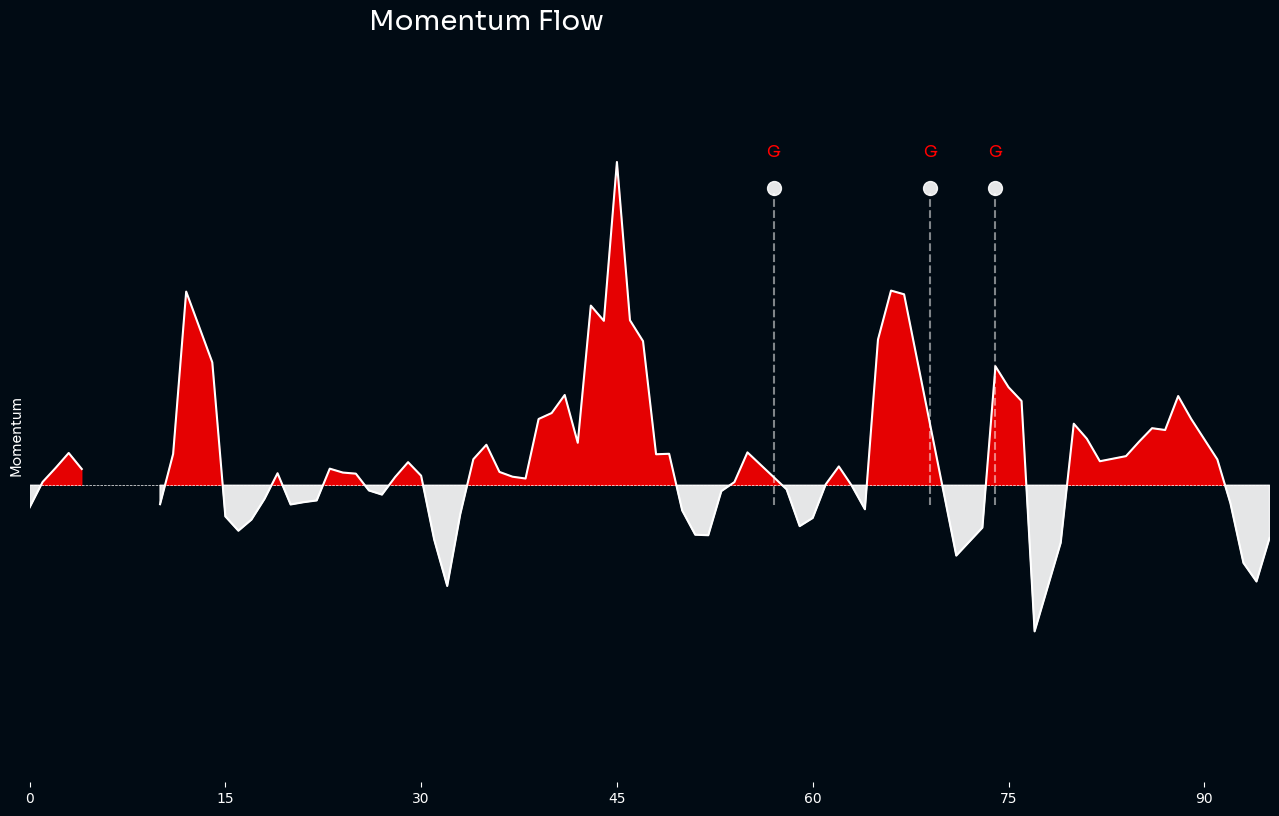

In [8]:
fig, ax = plt.subplots(figsize=(16, 9),facecolor=background)
hteam = 'Arsenal'
ateam = 'Real Madrid'
xT_momemtum(ax,df,hteam,ateam,'red','white')

## PPDA

In [56]:
def plot_ppda(df,flag,ax):
    #columns = ["minute", "second", "type", "outcomeType", "teamName", "oppositionTeamName", "name"]
    df_ppda = df.copy()
    goals = df[df['type'] == 'Goal'][['minute','second','teamName']]
    goals['timestamp'] = goals['minute'] * 60 + df_ppda['second']
    goals['time_bin'] = (goals['timestamp'] // 900).astype(int)
    # Step 1: Add a 'timestamp' column for easier time calculation
    df_ppda['timestamp'] = df_ppda['minute'] * 60 + df_ppda['second']
    
    # Step 2: Identify possessions
    if flag == True:
        df_ppda['possession_change'] = (df_ppda['teamName'] != df_ppda['teamName'].shift(1)) | (
            df_ppda['type'].isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge']) &
            (df_ppda['outcomeType'] == 'Successful')
        )
    else:
        df_ppda['possession_change'] = (df_ppda['teamName'] != df_ppda['teamName'].shift(1)) | (
            df_ppda['type'].isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge'])
        )

    df_ppda['possession_id'] = df_ppda['possession_change'].cumsum()
    
    
    df_ppda['timestamp'] = pd.to_numeric(df_ppda['timestamp'], errors='coerce')  # Convert non-numeric to NaN
    df_ppda = df_ppda.dropna(subset=['timestamp'])
    
    # Step 3: Aggregate possession data
    if flag == True:

        possessions = df_ppda.groupby('possession_id').agg(
            team=('teamName', 'first'),
            opposition=('oppositionTeamName', 'first'),
            passes=('type', lambda x: x.isin(['Pass']).sum()),
            defensive_actions=('type', 
                               lambda x: ((x.isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge'])) & 
                                          (df.loc[x.index, 'outcomeType'] == 'Successful')).sum())
        ).reset_index()

    else:
        possessions = df_ppda.groupby('possession_id').agg(
            team=('teamName', 'first'),
            opposition=('oppositionTeamName', 'first'),
            passes=('type', lambda x: x.isin(['Pass']).sum()),
            defensive_actions=('type', 
                               lambda x: ((x.isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge']))).sum())
        ).reset_index()

    # Step 4: Add time bins (e.g., 15-minute windows)
    df_ppda['time_bin'] = (df_ppda['timestamp'] // 900).astype(int)  # 900 seconds = 15 minutes
    
    # Step 5: Merge possession data with time bins
    possessions = possessions.merge(
        df_ppda[['possession_id', 'time_bin']].drop_duplicates(),
        on='possession_id',
        how='left'
    )
    
    # Step 6: Calculate PPDA for each time bin
    ppda = possessions.groupby(['time_bin', 'opposition']).agg(
        total_passes=('passes', 'sum'),
        total_def_actions=('defensive_actions', 'sum')
    ).reset_index()
    
    ppda['PPDA'] = ppda['total_passes'] / ppda['total_def_actions']
    ppda['PPDA'] = ppda['PPDA'].fillna(float('inf'))  # Handle cases with no defensive actions
    # Data preparation
    teams = ppda['opposition'].unique()  # List of teams
    
    #plt.figure(figsize=(10, 6), facecolor=background)  # Set figure background color to black
    #ax = plt.gca()
    ax.set_facecolor(background)
    
    # Plot PPDA values for each team
    for team in teams:
        team_data = ppda[ppda['opposition'] == team]
        if team == team1_name:
            plt.plot(team_data['time_bin'], team_data['PPDA'], label=team, marker='o',color=team1_facecolor,linewidth=3)
        else:
            plt.plot(team_data['time_bin'], team_data['PPDA'], label=team, marker='o',color=team2_facecolor,linewidth=3)
    
        # Annotate PPDA values on the plot
        for _, row in team_data.iterrows():
            plt.text(row['time_bin'], row['PPDA']+ 1.2, f"{row['PPDA']:.1f}", fontsize=12, ha='center', va='bottom', color='white')
    
    # Adjust Y-axis: reverse and set interval
    plt.gca().invert_yaxis()  # Reverse the y-axis
    plt.yticks(range(0, 21, 5), color='white')  # Set y-axis ticks and color
    plt.xticks(ppda['time_bin'].unique(), color='white')  # Set x-axis ticks and color
    
    
    ax = plt.gca()
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    # Chart formatting
    plt.title('Pressing Intensity - PPDA',fontproperties=font_prop, fontsize=25, color='white',y=1.05)
    plt.xlabel('Time Bin (15-minute intervals)', fontsize=12, color='white',fontproperties=font_prop)
    plt.ylabel('PPDA Value', fontsize=12, color='white',fontproperties=font_prop)
    plt.legend(title='Teams', facecolor='white', edgecolor='white', labelcolor='black', title_fontsize=10)

    plt.figtext(0.55, -0.05, "PPDA - Passes (Allowed) Per Defensive Action", wrap=True,fontproperties=font_prop, horizontalalignment='center', fontsize=15, color='white')
    plt.figtext(0.55, -0.1, "Lower Value Represents Higher Pressing Intensity", wrap=True,fontproperties=font_prop, horizontalalignment='center', fontsize=15, color='white')

    #for _, row in goals.iterrows():
    #    ymin, ymax = (0.1, 0.9)
        #ax.axvline(row['time_bin'], color='white', linestyle='--', linewidth=1.5, alpha=0.5, ymin=ymin, ymax=ymax)
    #    ax.scatter(row['time_bin'], (1 if row['teamName'] == team1_name else -0.8)*0.15, color='white', s=100, zorder=10, alpha=0.7)
     #   ax.text(row['time_bin'], (1.2 if row['teamName'] == team1_name else -0.85)*0.14, 'G',alpha=0.7, fontsize=15, ha='center', va='center', fontproperties=font_prop, color=team1_facecolor if row['teamName'] == team1_name else team2_facecolor)

    # Add grid with low opacity for better visibility
    plt.grid(alpha=0.5, color='grey')
    
    # Tight layout and show the chart
    plt.tight_layout()
    
    #plt.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/ACVInter/8.png',dpi=500,bbox_inches = 'tight',facecolor=background)

In [22]:
def plot_ppda(df, flag, ax):
    df_ppda = df.copy()
    goals = df[df['type'] == 'Goal'][['minute', 'second', 'teamName']]
    goals['timestamp'] = goals['minute'] * 60 + df_ppda['second']
    goals['time_bin'] = (goals['timestamp'] // 900).astype(int)
    
    # Step 1: Add a 'timestamp' column for easier time calculation
    df_ppda['timestamp'] = df_ppda['minute'] * 60 + df_ppda['second']
    
    # Step 2: Identify possessions
    if flag:
        df_ppda['possession_change'] = (df_ppda['teamName'] != df_ppda['teamName'].shift(1)) | (
            df_ppda['type'].isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge']) &
            (df_ppda['outcomeType'] == 'Successful')
        )
    else:
        df_ppda['possession_change'] = (df_ppda['teamName'] != df_ppda['teamName'].shift(1)) | (
            df_ppda['type'].isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge'])
        )

    df_ppda['possession_id'] = df_ppda['possession_change'].cumsum()
    
    df_ppda['timestamp'] = pd.to_numeric(df_ppda['timestamp'], errors='coerce')  # Convert non-numeric to NaN
    df_ppda = df_ppda.dropna(subset=['timestamp'])
    
    # Step 3: Aggregate possession data
    if flag:
        possessions = df_ppda.groupby('possession_id').agg(
            team=('teamName', 'first'),
            opposition=('oppositionTeamName', 'first'),
            passes=('type', lambda x: x.isin(['Pass']).sum()),
            defensive_actions=('type', 
                               lambda x: ((x.isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge'])) & 
                                          (df.loc[x.index, 'outcomeType'] == 'Successful')).sum())
        ).reset_index()
    else:
        possessions = df_ppda.groupby('possession_id').agg(
            team=('teamName', 'first'),
            opposition=('oppositionTeamName', 'first'),
            passes=('type', lambda x: x.isin(['Pass']).sum()),
            defensive_actions=('type', 
                               lambda x: ((x.isin(['Interception', 'Tackle', 'Clearance', 'BlockedPass','BallRecovery','Challenge']))).sum())
        ).reset_index()

    # Step 4: Add time bins (e.g., 15-minute windows)
    df_ppda['time_bin'] = (df_ppda['timestamp'] // 900).astype(int)  # 900 seconds = 15 minutes
    
    # Step 5: Merge possession data with time bins
    possessions = possessions.merge(
        df_ppda[['possession_id', 'time_bin']].drop_duplicates(),
        on='possession_id',
        how='left'
    )
    
    # Step 6: Calculate PPDA for each time bin
    ppda = possessions.groupby(['time_bin', 'opposition']).agg(
        total_passes=('passes', 'sum'),
        total_def_actions=('defensive_actions', 'sum')
    ).reset_index()
    
    ppda['PPDA'] = ppda['total_passes'] / ppda['total_def_actions']
    ppda['PPDA'] = ppda['PPDA'].fillna(float('inf'))  # Handle cases with no defensive actions
    
    # Data preparation
    teams = ppda['opposition'].unique()  # List of teams
    
    ax.set_facecolor(background)
    
    # Plot PPDA values for each team
    for team in teams:
        team_data = ppda[ppda['opposition'] == team]
        if team == hteam:
            ax.plot(team_data['time_bin'], team_data['PPDA'], label=team, marker='o', color=team1_facecolor, linewidth=3)
        else:
            ax.plot(team_data['time_bin'], team_data['PPDA'], label=team, marker='o', color=team2_facecolor, linewidth=3)
        
        # Annotate PPDA values on the plot
        for _, row in team_data.iterrows():
            ax.text(row['time_bin'], row['PPDA'] + 1.2, f"{row['PPDA']:.1f}", fontsize=12, ha='center', va='bottom', color='white')
    
    # Adjust Y-axis: reverse and set interval
    ax.invert_yaxis()  # Reverse the y-axis
    ax.set_yticks(range(0, 21, 5))  # Set y-axis ticks and color
    ax.set_xticks(ppda['time_bin'].unique())  # Set x-axis ticks and color
    
    # Customize spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    # Chart formatting
    ax.set_title('Pressing Intensity - PPDA', fontproperties=font_prop, fontsize=20, color='white', y=1.05)
    ax.set_xlabel('Time Bin (15-minute intervals)', fontsize=12, color='white', fontproperties=font_prop)
    ax.set_ylabel('PPDA Value', fontsize=12, color='white', fontproperties=font_prop)
    ax.legend(title='Teams', facecolor='white', edgecolor='white', labelcolor='black', title_fontsize=10)

    # Add grid with low opacity for better visibility
    ax.grid(alpha=0.5, color='grey')

    # Add additional text below the plot using the figure's figtext
    #ax.figure.figtext(0.55, -0.05, "PPDA - Passes (Allowed) Per Defensive Action", wrap=True, 
    #                  fontproperties=font_prop, horizontalalignment='center', fontsize=15, color='white')
    #ax.figure.figtext(0.55, -0.1, "Lower Value Represents Higher Pressing Intensity", wrap=True, 
    #                 fontproperties=font_prop, horizontalalignment='center', fontsize=15, color='white')

    # Tight layout and show the chart
    plt.tight_layout()


## Field Tilt

In [116]:
def plot_fieldtilt(df, ax):
    ## Ratio of each team’s final third touches compared to the total final third touches
    df_final_third = df[(df['x'] > 75) & (df['isTouch'] == 1) & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))]
    df_final_third['time_bin'] = np.floor(df_final_third['minute'] / 15).astype(int)
    
    final_third_touches = df_final_third.groupby(['time_bin', 'teamName']).size().reset_index(name='final_third_touches')
    total_touches = df_final_third.groupby('time_bin').size().reset_index(name='total_final_third_touches')
    
    field_tilt_data = final_third_touches.merge(total_touches, on='time_bin')
    field_tilt_data['Field Tilt'] = field_tilt_data['final_third_touches'] / field_tilt_data['total_final_third_touches']
    field_tilt_data = field_tilt_data[['time_bin', 'teamName', 'Field Tilt']]
    
    teams = field_tilt_data['teamName'].unique()  # List of teams
    
    # Set background color
    ax.set_facecolor(background)
    
    for team in teams:
        team_data = field_tilt_data[field_tilt_data['teamName'] == team]
        if team == hteam:
            ax.plot(team_data['time_bin'], team_data['Field Tilt'], label=team, marker='o', color=team1_facecolor, linewidth=3)
        else:
            ax.plot(team_data['time_bin'], team_data['Field Tilt'], label=team, marker='o', color=team2_facecolor, linewidth=3)
        
        for _, row in team_data.iterrows():
            ax.text(row['time_bin'], row['Field Tilt'] + 0.03, f"{row['Field Tilt']:.2f}", fontsize=12, ha='center', va='bottom', color='white')
    
    # Adjust Y-axis
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xticks(field_tilt_data['time_bin'].unique())
    
    # Set tick colors
    ax.tick_params(axis='both', colors='white')
    
    # Customize spines
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    
    # Chart formatting
    ax.set_title('Field Tilt', fontproperties=font_prop, fontsize=25, color='white', y=1.05)
    ax.set_xlabel('Time Bin (15-minute intervals)', fontsize=12, color='white', fontproperties=font_prop)
    ax.set_ylabel('Tilt Value', fontsize=12, color='white', fontproperties=font_prop)
    ax.legend(title='Teams', facecolor='white', edgecolor='white', labelcolor='black', title_fontsize=10)
    
    # Add grid
    ax.grid(alpha=0.5, color='grey')
    
    # Add additional text below the plot
    #plt.figtext(0.5, -0.05, "Ratio of each team’s final third touches compared to the total final third touches", 
    #            wrap=True, fontproperties=font_prop, horizontalalignment='center', fontsize=15, color='white')




## Average Positions

In [39]:
def scrape_average_positions(matchId):
    response = requests.get(f'https://www.sofascore.com/api/v1/event/{matchId}/average-positions')
    response2 = requests.get(f'https://www.sofascore.com/api/v1/event/{matchId}/lineups')
    avg_pos = response.json()
    lineups = response2.json()

    home_positions = []
    away_positions = []
    
    home_positions.append(pd.json_normalize(avg_pos['home']))
    away_positions.append(pd.json_normalize(avg_pos['away']))
    
    df_home_pos = pd.concat(home_positions, ignore_index=True)
    df_away_pos = pd.concat(away_positions, ignore_index=True)
    
    home_lineups = []
    away_lineups = []
    
    home_lineups.append(pd.json_normalize(lineups['home']['players']))
    away_lineups.append(pd.json_normalize(lineups['away']['players']))
    
    # Concatenate all home and away data into separate DataFrames
    df_home_lineup = pd.concat(home_lineups, ignore_index=True)
    df_away_lineup = pd.concat(away_lineups, ignore_index=True)

    return df_home_lineup,df_away_lineup,df_home_pos,df_away_pos
    
mi = 12436627
df_home_lineup,df_away_lineup,df_home_pos,df_away_pos = scrape_average_positions(mi)

In [53]:
def plot_average_pos(ax,df_lineup,df_pos,players_df,team,teamcolor,flipped=True):

    teamId = df[df['teamName'] == team]['teamId'].iloc[0]
    #ateamId = df[df['teamName'] == ateam]['teamId'].iloc[0]

    player_no = players_df[(players_df['teamId'] == teamId) & (players_df['isFirstEleven'] == True)]['shirtNo'].unique().tolist()
    #away_player_names = players_df[(players_df['teamId'] == ateamId) & (players_df['isFirstEleven'] == True)]['shirtNo'].unique().tolist()

    df_avg_pos = df_pos[df_pos['player.jerseyNumber'].astype(int).isin(player_no)]
    #df_away_avg_pos = df_away_pos[df_away_pos['player.jerseyNumber'].astype(int).isin(away_player_names)]

    pitch = Pitch(pitch_type='opta',positional=True, shade_middle=True, positional_color='grey',positional_alpha=0.5,
                          shade_color='grey',shade_alpha=0.5,line_color='white',pitch_color=background,axis=False,linewidth=1.5)
    pitch.draw(ax=ax)
    #ax.text(30,110,"Average Positions", color='white', fontsize=25,fontproperties=font_prop)

    if flipped==False:
        ax.invert_xaxis()
        ax.invert_yaxis()

    if team_name == hteam:
        ax.text(30,75,"Average Positions", color='white', fontsize=25,fontproperties=font_prop)
    else:
        ax.text(70,-5,"Average Positions", color='white', fontsize=25,fontproperties=font_prop)
        

    for index,row in df_avg_pos.iterrows():
        pitch.scatter(row['averageX'],row['averageY'],color=teamcolor, s=1200, edgecolor='white', linewidth=1, alpha=0.9,marker='o',ax=ax)
        pitch.annotate(row['player.jerseyNumber'],xy = (row['averageX'],row['averageY']),color='white',ha='center', va='center',fontsize=18,fontproperties=font_prop,ax=ax)

    return

## Corners

In [357]:
def get_next_events_by_index(df, current_index, num_events, target_types=None):
    """
    Get the next consecutive rows based on DataFrame indices and filter by event type.
    Only process if the current event is of type 'Pass'.
    """
    # Check if the current event is a 'Pass'
    if df.loc[current_index, 'type'] != 'Pass':
        return []  # Return an empty list if the type is not 'Pass'

    # Get the valid range of indices for the next events
    max_index = len(df) - 1
    next_indices = [i for i in range(current_index + 1, current_index + 1 + num_events) if i <= max_index]
    
    # Fetch the rows using the valid indices
    next_events = df.iloc[next_indices].reset_index(drop=True)
    
    # Filter for relevant types, if provided
    if target_types:
        next_events = next_events[next_events['type'].isin(target_types)]
    
    return next_events.to_dict('records')

def extract_last_shot_coordinates(next_events):
    if next_events:
        # Filter out events that are shots (Shot types: 'SavedShot', 'MissedShot', 'ShotOnPost', 'Goal')
        shot_events = [event for event in next_events if event['type'] in ['SavedShot', 'MissedShots', 'ShotOnPost', 'Goal']]
        if shot_events:
            # Get the coordinates of the last shot event
            last_shot = shot_events[-1]
            return last_shot['x'], last_shot['y']
    return None, None  # Return None if no shots found


In [358]:
# Define the target types
target_types = ['SavedShot', 'MissedShots', 'ShotOnPost', 'Goal']
# Add next events for corners_1 using indices
df['next_events'] = df.index.map(
    lambda idx: get_next_events_by_index(df, idx, num_events=10, target_types=target_types)
)

corners = df[df['IsCorner'] == True]

corners['side'] = corners.apply(lambda row: 'Left' if round(row['y'], 3) == 67.660 else 'Right', axis=1)

corners['next_events_type'] = corners['next_events'].apply(
    lambda next_events: [event['type'] for event in next_events] if next_events else None
)

corners['shot_name'] = corners['next_events'].apply(
    lambda next_events: [event['name'] for event in next_events] if next_events else None
)

# Apply the function to extract coordinates for corners_1
corners['next_shot_x'], corners['next_shot_y'] = zip(*corners['next_events'].apply(extract_last_shot_coordinates))

C:\Users\acer\AppData\Local\Temp\ipykernel_42536\225135072.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corners['side'] = corners.apply(lambda row: 'Left' if round(row['y'], 3) == 67.660 else 'Right', axis=1)
C:\Users\acer\AppData\Local\Temp\ipykernel_42536\225135072.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corners['next_events_type'] = corners['next_events'].apply(
C:\Users\acer\AppData\Local\Temp\ipykernel_42536\225135072.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

In [360]:
def plot_corners(corners_df,team1,team2,team1_color,team2_color):
    corners_1 = corners[(corners['side'] == 'Left') & (corners['teamName'] == team1)].copy()
    corners_2 = corners[(corners['side'] == 'Right')  & (corners['teamName'] == team1)].copy()
    corners_3 = corners[(corners['side'] == 'Left') & (corners['teamName'] == team2)].copy()
    corners_4 = corners[(corners['side'] == 'Right')  & (corners['teamName'] == team2)].copy()

    def process_corners(df):
        if df.empty:
            return pd.DataFrame({'x':[0],'endX':[0],'endY':[0], 'y':[0],'next_shot_x':[0],'next_shot_y':[0],'total_shots': [0], 'goals': [0], 'shots_ot': [0]}, index=pd.Index(['Empty'], name='type'))
        
        # Calculate the number of shots (next_events_type is not None)
        df['total_shots'] = df['next_events_type'].apply(
            lambda x: 1 if x is not None else 0
        )
        df['goals'] = df['next_events_type'].apply(
            lambda x: 1 if 'Goal' in (x if isinstance(x, list) else [x]) else 0
        )
        #df['shots_ot'] = df['next_events_type'].apply(
        #    lambda x: 1 if 'SavedShot' in (x if isinstance(x, list) else [x]) else 0
        #)
        df['shots_ot'] = df['next_events_type'].apply(
            lambda x: 1 if any(event in (x if isinstance(x, list) else [x]) for event in ['SavedShot', 'Goal']) else 0
        )

        
        return df

    # Process both sides
    corners_1 = process_corners(corners_1)
    corners_2 = process_corners(corners_2)
    corners_3 = process_corners(corners_3)
    corners_4 = process_corners(corners_4)

    # Now you can calculate the total number of shots and goals by corner type
    shots_by_corner_type_1 = corners_1.groupby('type')['total_shots'].sum()
    goals_by_corner_type_1 = corners_1.groupby('type')['goals'].sum()
    shots_ot_by_corner_type_1 = corners_1.groupby('type')['shots_ot'].sum()
    
    shots_by_corner_type_2 = corners_2.groupby('type')['total_shots'].sum()
    goals_by_corner_type_2 = corners_2.groupby('type')['goals'].sum()
    shots_ot_by_corner_type_2 = corners_2.groupby('type')['shots_ot'].sum()

    shots_by_corner_type_3 = corners_3.groupby('type')['total_shots'].sum()
    goals_by_corner_type_3 = corners_3.groupby('type')['goals'].sum()
    shots_ot_by_corner_type_3 = corners_3.groupby('type')['shots_ot'].sum()

    shots_by_corner_type_4 = corners_4.groupby('type')['total_shots'].sum()
    goals_by_corner_type_4 = corners_4.groupby('type')['goals'].sum()
    shots_ot_by_corner_type_4 = corners_4.groupby('type')['shots_ot'].sum()
    
    # Combine them to get a complete picture
    corner_summary_1 = pd.DataFrame({
        'total_shots': shots_by_corner_type_1,
        'goals': goals_by_corner_type_1,
        'shots_ot': shots_ot_by_corner_type_1
    })
    
    corner_summary_2 = pd.DataFrame({
        'total_shots': shots_by_corner_type_2,
        'goals': goals_by_corner_type_2,
        'shots_ot': shots_ot_by_corner_type_2
    })

    corner_summary_3 = pd.DataFrame({
        'total_shots': shots_by_corner_type_3,
        'goals': goals_by_corner_type_3,
        'shots_ot': shots_ot_by_corner_type_3
    })

    corner_summary_4 = pd.DataFrame({
        'total_shots': shots_by_corner_type_4,
        'goals': goals_by_corner_type_4,
        'shots_ot': shots_ot_by_corner_type_4
    })

    FIGWIDTH = 12
    FIGHEIGHT = 9
    NROWS = 2
    NCOLS = 2
    SPACE = 0
    MAX_GRID = 0.95
    
    pitch = VerticalPitch(pitch_type='uefa',pad_bottom=-15,line_color='white',goal_type='box', linewidth=0.5, half=True,
                          pitch_color=background)
    
    GRID_WIDTH, GRID_HEIGHT = pitch.grid_dimensions(figwidth=FIGWIDTH, figheight=FIGHEIGHT,
                                                    nrows=NROWS, ncols=NCOLS,
                                                    max_grid=MAX_GRID, space=SPACE)
    TITLE_HEIGHT = 0.01
    ENDNOTE_HEIGHT = 0
    
    fig, ax = pitch.grid(figheight=FIGHEIGHT, grid_width=GRID_WIDTH, grid_height=GRID_HEIGHT,
                         space=SPACE, ncols=NCOLS, nrows=NROWS, title_height=TITLE_HEIGHT,
                         endnote_height=ENDNOTE_HEIGHT, axis=False)
    fig.set_facecolor(background)
    fig.suptitle(f'Corner Analysis', fontsize=30,fontproperties=font_prop, color='white', y=0.92)
    img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{team1}.png')
    ax_image = add_image(
        img_team1, fig, left=0.2, bottom=0.85, width=0.12, height=0.12,aspect='equal'
    )

    img_team2 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{team2}.png')
    ax_image = add_image(
        img_team2, fig, left=0.68, bottom=0.85, width=0.12, height=0.12,aspect='equal'
    )

    if not corners_1.empty:
        pitch.arrows(corners_1.x, corners_1.y,
                     corners_1.endX, corners_1.endY, width=1.5,alpha=0.8,zorder=3,
                     headwidth=8, headlength=5, color='white', ax=ax['pitch'][0,0], label='Corners From Left')
        pitch.scatter(corners_1.next_shot_x, corners_1.next_shot_y,s=500,marker='p',color=team1_color,zorder=2,alpha=0.9, ax=ax['pitch'][0,0], edgecolors='white')

    if not corners_2.empty:
        pitch.arrows(corners_2.x, corners_2.y,
                     corners_2.endX, corners_2.endY, width=1.5,alpha=0.8,zorder=3,
                     headwidth=8, headlength=5, color='white', ax=ax['pitch'][1,0], label='Corners From Right')
        pitch.scatter(corners_2.next_shot_x, corners_2.next_shot_y,s=500,marker='p',color=team1_color,zorder=2,alpha=0.9, ax=ax['pitch'][1,0], edgecolors='white')

    pitch.scatter(80,45,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,0])
    pitch.annotate(corner_summary_1['total_shots'][0],xy = (80,45),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    pitch.annotate('Shots',xy = (75,45),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    
    pitch.scatter(80,34,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,0])
    pitch.annotate(corner_summary_1['shots_ot'][0],xy = (80,34),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    pitch.annotate('Shots(OT)',xy = (75,34),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    
    pitch.scatter(80,23,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,0])
    pitch.annotate(corner_summary_1['goals'][0],xy = (80,23),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    pitch.annotate('Goals',xy = (75,23),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,0])
    
    
    pitch.scatter(80,45,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,0])
    pitch.annotate(corner_summary_2['total_shots'][0],xy = (80,45),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])
    pitch.annotate('Shots',xy = (75,45),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])
    
    pitch.scatter(80,34,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,0])
    pitch.annotate(corner_summary_2['shots_ot'][0],xy = (80,34),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])
    pitch.annotate('Shots(OT)',xy = (75,34),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])
    
    
    pitch.scatter(80,23,color=team1_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,0])
    pitch.annotate(corner_summary_2['goals'][0],xy = (80,23),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])
    pitch.annotate('Goals',xy = (75,23),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,0])

    if not corners_3.empty:
        pitch.arrows(corners_3.x, corners_3.y,
                     corners_3.endX, corners_3.endY, width=1.5,alpha=0.8,zorder=3,
                     headwidth=8, headlength=5, color='white', ax=ax['pitch'][0,1], label='Corners From Left')
        pitch.scatter(corners_3.next_shot_x, corners_3.next_shot_y,s=500,marker='p',color=team2_color,zorder=2,alpha=0.5, ax=ax['pitch'][0,1], edgecolors='white')

    if not corners_4.empty:
        pitch.arrows(corners_4.x, corners_4.y,
                     corners_4.endX, corners_4.endY, width=1.5,alpha=0.8,zorder=3,
                     headwidth=8, headlength=5, color='white', ax=ax['pitch'][1,1], label='Corners From Right')
        pitch.scatter(corners_4.next_shot_x, corners_4.next_shot_y,s=500,marker='p',color=team2_color,zorder=2,alpha=0.9, ax=ax['pitch'][1,1], edgecolors='white')

    pitch.scatter(80,45,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,1])
    pitch.annotate(corner_summary_3['total_shots'][0],xy = (80,45),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    pitch.annotate('Shots',xy = (75,45),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    
    pitch.scatter(80,34,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,1])
    pitch.annotate(corner_summary_3['shots_ot'][0],xy = (80,34),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    pitch.annotate('Shots(OT)',xy = (75,34),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    
    pitch.scatter(80,23,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][0,1])
    pitch.annotate(corner_summary_3['goals'][0],xy = (80,23),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    pitch.annotate('Goals',xy = (75,23),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][0,1])
    
    
    pitch.scatter(80,45,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,1])
    pitch.annotate(corner_summary_4['total_shots'][0],xy = (80,45),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])
    pitch.annotate('Shots',xy = (75,45),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])
    
    pitch.scatter(80,34,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,1])
    pitch.annotate(corner_summary_4['shots_ot'][0],xy = (80,34),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])
    pitch.annotate('Shots(OT)',xy = (75,34),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])
    
    
    pitch.scatter(80,23,color=team2_color, s=1000, edgecolor='white', linewidth=2, alpha=0.7,marker='o',zorder=2,ax=ax['pitch'][1,1])
    pitch.annotate(corner_summary_4['goals'][0],xy = (80,23),color='white',ha='center', va='center',fontsize=15,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])
    pitch.annotate('Goals',xy = (75,23),color='white',ha='center', va='center',fontsize=12,zorder=3,fontproperties=font_prop,ax=ax['pitch'][1,1])

    #fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/ACVInter/10.png',dpi=500,bbox_inches = 'tight',facecolor=background)

## Possession Lost

In [361]:


def plot_lost_pos(df,ax,team1_name,team2_name,team1_facecolor,team2_facecolor):
    df_lost_pos = df[
    ((df['type'] == 'Dispossessed') & (df['outcomeType'] == 'Successful')) |
    ((df['type'] == 'BallTouch') & (df['outcomeType'] == 'Unsuccessful'))
    ]
    
    # Group by 'teamName' and 'name', then get the counts
    grouped_df = df_lost_pos.groupby(['teamName', 'name']).size().reset_index(name='counts')
    
    # Filter for Team A
    team_a_df = grouped_df[grouped_df['teamName'] == team1_name]
    players_team_a = team_a_df['name'].tolist()
    counts_team_a = team_a_df['counts'].tolist()
    
    # Filter for Team B
    team_b_df = grouped_df[grouped_df['teamName'] == team2_name]
    players_team_b = team_b_df['name'].tolist()
    counts_team_b = team_b_df['counts'].tolist()
    # Comparing open play touches of both teams in each zones of the pitch, if more than 55% touches for a team it will be coloured of that team, otherwise gray to represent contested
    pcmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",  [team2_facecolor, 'gray', team1_facecolor], N=20)
    df1 = df[(df['teamName']==team1_name)]
    df2 = df[(df['teamName']==team2_name)]
    df2['x'] = 105-df2['x']
    df2['y'] =  68-df2['y']
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=1, line_zorder=4)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5,68.5)
    #ax.set_xlim(-0.5,105.5)

    pitch.scatter(df1.x, df1.y,s=500,marker='p',color=team1_facecolor,zorder=4,alpha=0.9, ax=ax, edgecolors='white')

    pitch.scatter(df2.x, df2.y,s=500,marker='p',color=team2_facecolor,zorder=4,alpha=0.9, ax=ax, edgecolors='white')
    ax.text(0,  -3, 'Attacking Direction--->', color=team1_facecolor, fontsize=15, ha='left', va='center',font_properties=font_prop)
    ax.text(105,-3, '<---Attacking Direction', color=team2_facecolor, fontsize=15, ha='right', va='center',font_properties=font_prop)

    ax.text(53,  73, 'Possession Lost', color='white', fontsize=30, ha='center', va='center',font_properties=font_prop)

    grouped_df = df.groupby(['teamName', 'name']).size().reset_index(name='counts')

    # Filter for Team A
    team_a_df = grouped_df[grouped_df['teamName'] == team1_name]
    players_team_a = team_a_df['name'].tolist()
    counts_team_a = team_a_df['counts'].tolist()
    
    # Filter for Team B
    team_b_df = grouped_df[grouped_df['teamName'] == team2_name]
    players_team_b = team_b_df['name'].tolist()
    counts_team_b = team_b_df['counts'].tolist()
    # Display the player names and counts for Team 1 on the left side
    for i, (player, count) in enumerate(zip(players_team_a, counts_team_a)):
        ax.text(-25, 68 - (i * 6.5), f"{player}: {count}", color=team1_facecolor, fontsize=15, ha='left', va='top', font_properties=font_prop)
    
    # Display the player names and counts for Team 2 on the right side
    for i, (player, count) in enumerate(zip(players_team_b, counts_team_b)):
        ax.text(130, 68 - (i * 6.5), f"{player}: {count}", color=team2_facecolor, fontsize=15, ha='right', va='top', font_properties=font_prop)
        
    return

## Final Third Entries

In [124]:
def Final_third_entry(ax, team_name, col):
    # Final third Entry means passes or carries which has started outside the Final third and ended inside the final third
    dfpass = df[(df['teamName']==team_name) & (df['type']=='Pass') & (df['x']<75) & (df['endX']>=75) & (df['outcomeType']=='Successful') &
                (~df['qualifiers'].str.contains('Freekick'))]
    dfcarry = df[(df['teamName']==team_name) & (df['type']=='Carry') & (df['x']<75) & (df['endX']>=75)]
    pitch = Pitch(pitch_type='uefa', pitch_color=background, line_color='white', linewidth=1,
                          corner_arcs=True)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    if team_name == ateam:
        ax.invert_xaxis()
        ax.invert_yaxis()

    pass_count = len(dfpass) + len(dfcarry)

    # calculating the counts
    left_entry = len(dfpass[dfpass['y']>=45.33]) + len(dfcarry[dfcarry['y']>=45.33])
    mid_entry = len(dfpass[(dfpass['y']>=22.67) & (dfpass['y']<45.33)]) + len(dfcarry[(dfcarry['y']>=22.67) & (dfcarry['y']<45.33)])
    right_entry = len(dfpass[(dfpass['y']>=0) & (dfpass['y']<22.67)]) + len(dfcarry[(dfcarry['y']>=0) & (dfcarry['y']<22.67)])
    left_percentage = round((left_entry/pass_count)*100)
    mid_percentage = round((mid_entry/pass_count)*100)
    right_percentage = round((right_entry/pass_count)*100)

    ax.hlines(22.67, xmin=0, xmax=70, colors='white', linestyle='dashed', alpha=0.35)
    ax.hlines(45.33, xmin=0, xmax=70, colors='white', linestyle='dashed', alpha=0.35)
    ax.vlines(70, ymin=-2, ymax=70, colors='white', linestyle='dashed', alpha=0.55)

    # showing the texts in the pitch
    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="None", facecolor=background, alpha=0.75)
    if col == team1_facecolor or col == 'white':
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color='white', fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color='white', fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color='white', fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
    else:
        ax.text(8, 11.335, f'{right_entry}\n({right_percentage}%)', color=team2_facecolor, fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 34, f'{mid_entry}\n({mid_percentage}%)', color=team2_facecolor, fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)
        ax.text(8, 56.675, f'{left_entry}\n({left_percentage}%)', color=team2_facecolor, fontsize=15, va='center', ha='center', bbox=bbox_props,fontproperties=font_prop)

    # plotting the passes
    pro_pass = pitch.lines(dfpass.x, dfpass.y, dfpass.endX, dfpass.endY, lw=3, comet=True, color=col, ax=ax, alpha=0.5)
    # plotting some scatters at the end of each pass
    pro_pass_end = pitch.scatter(dfpass.endX, dfpass.endY, s=35, edgecolor=col, linewidth=1, color=background, zorder=2, ax=ax)
    # plotting carries
    for index, row in dfcarry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=1.5, linestyle='--')
        ax.add_patch(arrow)

    counttext = f"{pass_count} Final Third Entries"

    # Heading and other texts
    if col == team1_facecolor or col == 'white':
        ax.text(50,80,f"{counttext}", color='white', fontsize=20, fontweight='bold',ha='center', va='center', path_effects=path_eff,fontproperties=font_prop)
        ax.text(87.5, 70, '<------- Final third ------->', color='white', ha='center', va='center',fontproperties=font_prop)
        pitch.lines(53, -2, 73, -2, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,-2, s=35, edgecolor=col, linewidth=1, color=background, zorder=2)
        arrow = patches.FancyArrowPatch((83, -2), (103, -2), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, -5, f'Entry by Pass: {len(dfpass)}', fontsize=10, color='white', ha='center', va='center',fontproperties=font_prop)
        ax.text(93, -5, f'Entry by Carry: {len(dfcarry)}', fontsize=10, color='white', ha='center', va='center',fontproperties=font_prop)

    else:
        ax.text(50,-12,f"{counttext}", color='white', fontsize=20, fontweight='bold',ha='center', va='center', path_effects=path_eff,fontproperties=font_prop)
        ax.text(87.5, -2, '<----- Final third ----->', color='white', ha='center', va='center',fontproperties=font_prop)
        pitch.lines(53, 70, 73, 70, lw=3, transparent=True, comet=True, color=col, ax=ax, alpha=0.5)
        ax.scatter(73,70, s=35, edgecolor=col, linewidth=1, color=background, zorder=2)
        arrow = patches.FancyArrowPatch((83, 70), (103, 70), arrowstyle='->', color=col, zorder=4, mutation_scale=20,
                                        alpha=1, linewidth=2, linestyle='--')
        ax.add_patch(arrow)
        ax.text(63, 73, f'Entry by Pass: {len(dfpass)}', fontsize=10, color='white', ha='center', va='center',fontproperties=font_prop)
        ax.text(93, 73, f'Entry by Carry: {len(dfcarry)}', fontsize=10, color='white', ha='center', va='center',fontproperties=font_prop)

    return {
        'Team_Name': team_name,
        'Total_Final_Third_Entries': pass_count,
        'Final_Third_Entries_From_Left': left_entry,
        'Final_Third_Entries_From_Center': mid_entry,
        'Final_Third_Entries_From_Right': right_entry,
        'Entry_By_Pass': len(dfpass),
        'Entry_By_Carry': len(dfcarry)
    }


## Viz

C:\Users\acer\AppData\Local\Temp\ipykernel_101304\2751274056.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['x'] = 105-df2['x']
C:\Users\acer\AppData\Local\Temp\ipykernel_101304\2751274056.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['y'] =  68-df2['y']
C:\Users\acer\AppData\Local\Temp\ipykernel_101304\2751274056.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

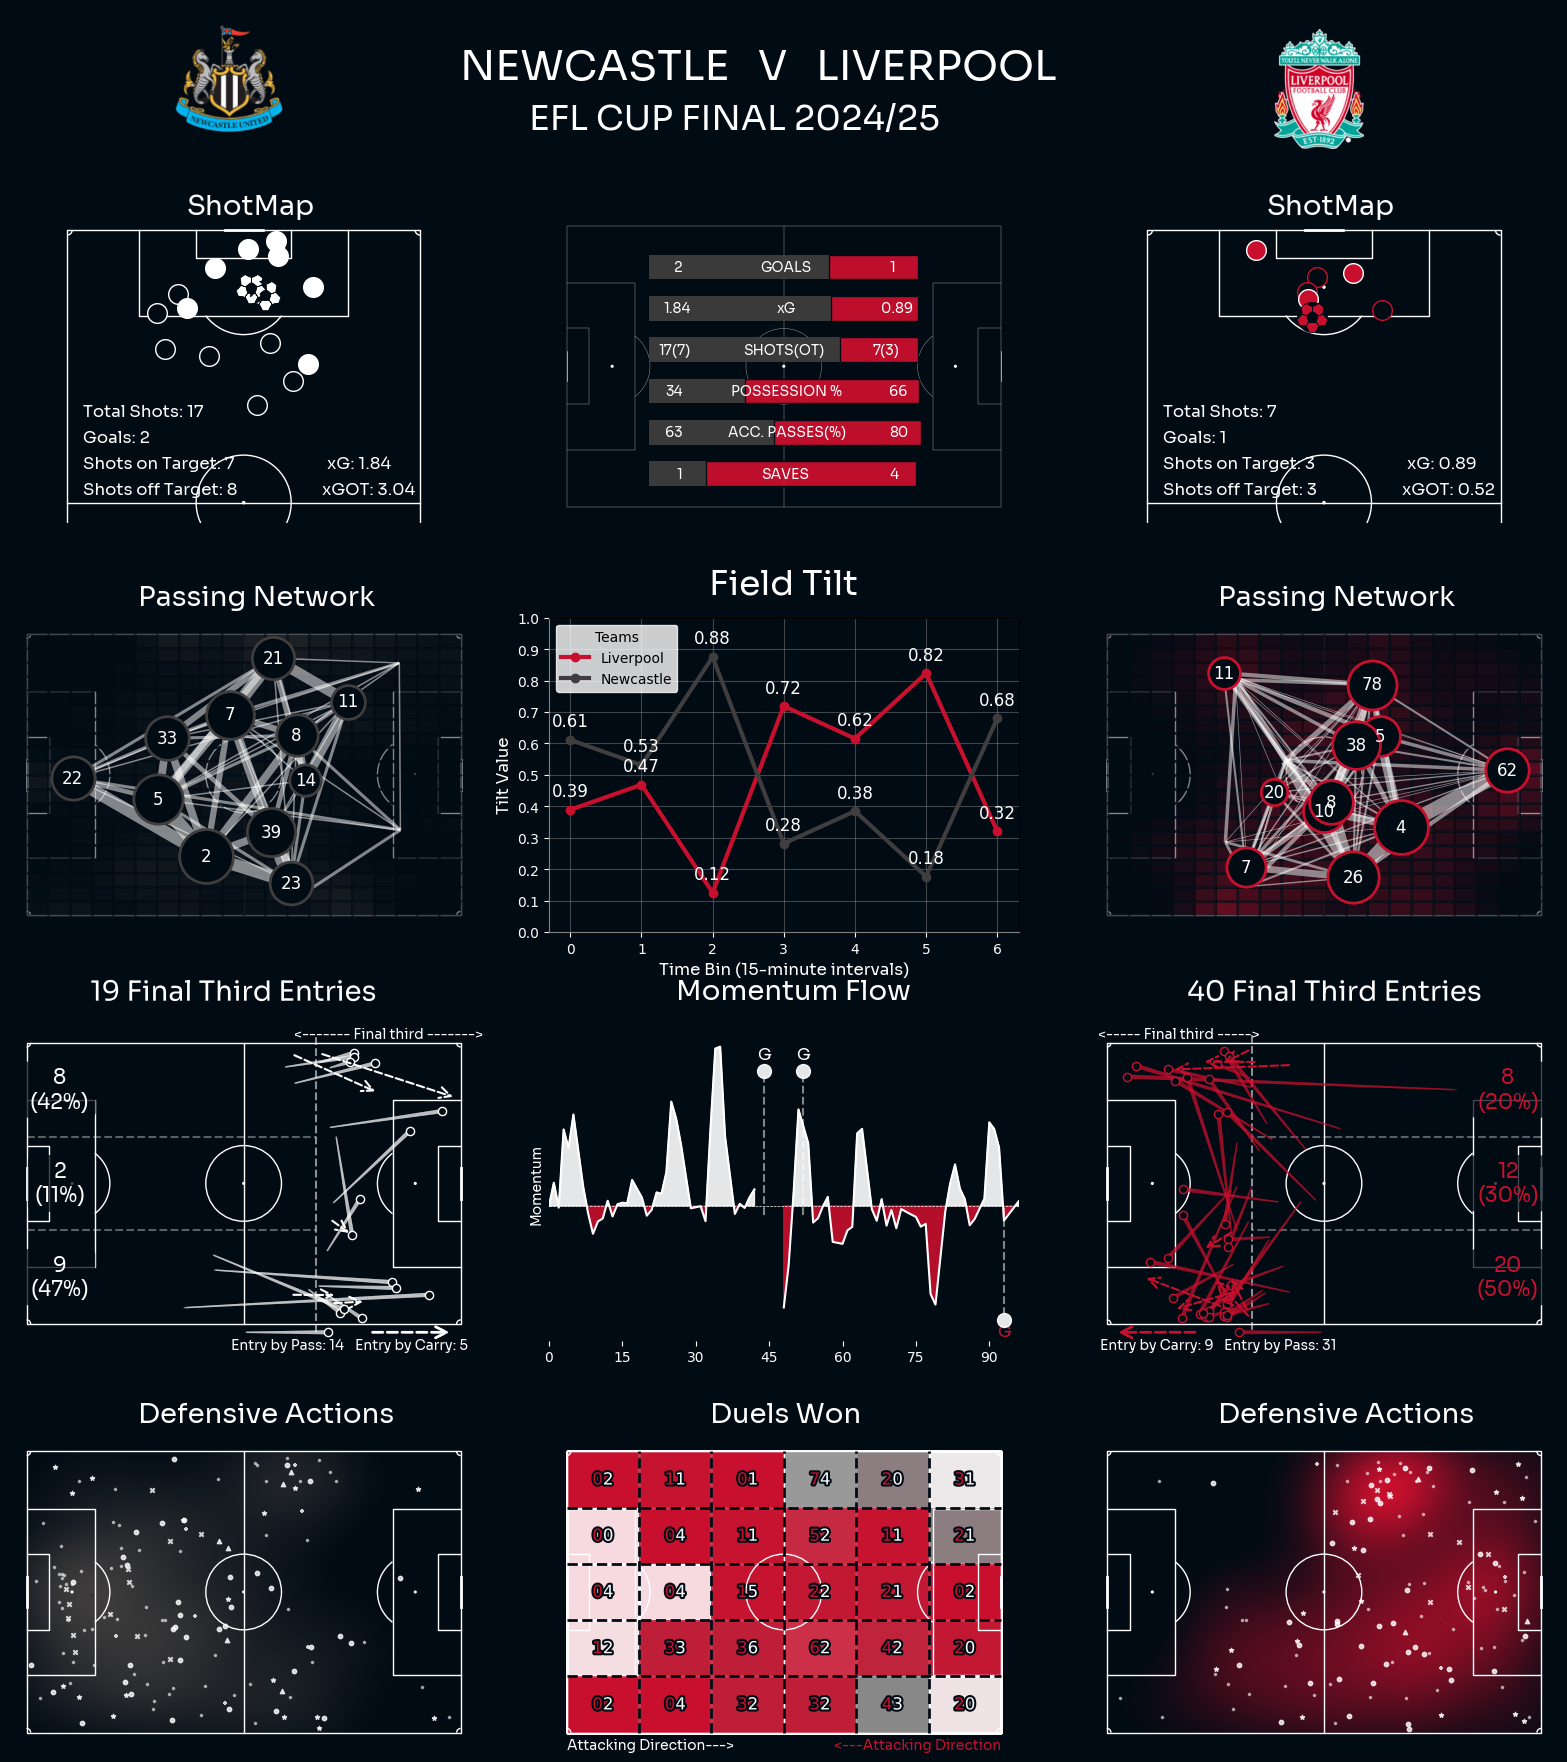

In [126]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20), facecolor=background)
league = 'EFL Cup Final 2024/25'
#stadium = 'Etihad'

#hteam = 'Brighton'
#ateam = 'Liverpool'
team1_facecolor = '#3F3D3D'
team2_facecolor = '#c8102E'

fig.suptitle(f'{hteam.upper()}   V   {ateam.upper()}', fontsize=30,fontproperties=font_prop, color='white', y=0.96)
fig.text(0.385,0.92,f'{league.upper()}',fontsize=25,fontproperties=font_prop, color='white')
img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{hteam}.png')
img_team2 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{ateam}.png')
ax_image = add_image(
    img_team1, fig, left=0.2, bottom=0.91, width=0.07, height=0.07,aspect='equal'
)
ax_image = add_image(
    img_team2, fig, left=0.75, bottom=0.91, width=0.06, height=0.06,aspect='equal'
)

#shotMap_ws(axes[1,1],hteam,ateam,team1_facecolor,team2_facecolor)
#shotmap(hteam,ateam,team1_facecolor,team2_facecolor,home_shots_df,away_shots_df,axes[1,1])

shotMap_ws(axes[0,0],hteam,'white',1.84,3.04)
shotMap_ws(axes[0,2],ateam,team2_facecolor,0.89,0.52)

#match_stats(axes[0,1],team1_facecolor,team2_facecolor,34,66,63,80,1,4)
match_stats_ws(axes[0,1],team1_facecolor,team2_facecolor,34,66,63,80,1,4,1.84,0.89)

#shotmap_v2(axes[0,0],hteam,team1_facecolor,home_shots_df)
#shotmap_v2(axes[0,2],ateam,team2_facecolor,away_shots_df)

pass_network_visualization(axes[1,0],df, home_passes_between_df, home_average_locs_and_count_df, team1_facecolor, hteam,10)
pass_network_visualization(axes[1,2],df, away_passes_between_df, away_average_locs_and_count_df, team2_facecolor, ateam,10,True)

plot_congestion(axes[3,1],df,hteam,ateam,'white',team2_facecolor)

xT_momemtum(axes[2,1],df,hteam,ateam,'white',team2_facecolor)


#plot_average_pos(axes[0,0],df_home_lineup,df_home_pos,players_df,hteam,team1_facecolor)
#plot_average_pos(axes[0,2],df_away_lineup,df_away_pos,players_df,ateam,team2_facecolor,False)

Final_third_entry(axes[2,0], hteam, 'white')
Final_third_entry(axes[2,2], ateam, team2_facecolor)

defensive_block(axes[3,0], defensive_home_average_locs_and_count_df, hteam, team1_facecolor)
defensive_block(axes[3,2], defensive_home_average_locs_and_count_df, ateam, team2_facecolor,True)

#xgFlow(axes[1,1],home_shots_df,away_shots_df,hteam,ateam,team1_facecolor,team2_facecolor)
#plot_ppda(df,True,axes[1,1])
plot_fieldtilt(df,axes[1,1])

plt.subplots_adjust(wspace=0.15)
plt.subplots_adjust(hspace=0.3)

fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/Dashboards/{hteam}V{ateam}.png',dpi=500,bbox_inches = 'tight',facecolor=background)

# Player Dashboard

In [53]:
df['name'].unique()

array(['nan', 'Youri Tielemans', 'Emiliano Martinez', 'Ruben Dias',
       'Ezri Konsa', 'Boubacar Kamara', 'Marcus Rashford',
       'Stefan Ortega', 'Amadou Onana', 'Matty Cash', 'Morgan Rogers',
       'Josko Gvardiol', 'Bernardo Silva', 'Ilkay Gundogan',
       'Omar Marmoush', 'Kevin De Bruyne', 'Jacob Ramsey',
       'Matheus Nunes', 'Mateo Kovacic', 'James McAtee', 'Lucas Digne',
       'Pau Torres', "Nico O'Reilly", 'Axel Disasi', 'John McGinn',
       'Jeremy Doku', 'Ollie Watkins', 'Marco Asensio', 'Donyell Malen',
       'Manuel Akanji'], dtype=object)

### Passmap

In [89]:
df.columns

Index(['index', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'relatedEventId', 'relatedPlayerId', 'isGoal_x', 'cardType_x',
       'isOwnGoal_x', 'cumulative_mins', 'isGoal_y', 'cardType_y',
       'isOwnGoal_y', 'x1_bin_xT', 'y1_bin_xT', 'x2_bin_xT', 'y2_bin_xT',
       'start_zone_value_xT', 'end_zone_value_xT', 'xT', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'prog_pass', 'prog_carry', 'pass_or_carry_angle', 'shortName',
       'Pass Type', 'Carry Type', 'IsCorner'],
      dtype='object')

In [90]:
df[(df['qualifiers'].str.contains('ShotAssist')) & (df['name'] == pname)]

,index,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,relatedEventId,relatedPlayerId,isGoal_x,cardType_x,isOwnGoal_x,cumulative_mins,isGoal_y,cardType_y,isOwnGoal_y,x1_bin_xT,y1_bin_xT,x2_bin_xT,y2_bin_xT,start_zone_value_xT,end_zone_value_xT,xT,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,prog_pass,prog_carry,pass_or_carry_angle,shortName,Pass Type,Carry Type,IsCorner
197,198,96.0,9.0,30.0,65,80.955,19.04,9.0,FirstHalf,Pass,Successful,"[{'type': {'value': 141, 'displayName': 'PassE...","[91, 119, 117, 30, 123, 205, 40, 46, 36, 37, 2...",True,480249.0,89.985,33.932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5,NaN,NaN,NaN,9.0,2.0,10.0,3.0,0.028552,0.108051,0.079499,Barcelona,Benfica,19.0,Lamine Yamal,AMR,True,13.303808,0.0,58.768809,L. Yamal,Side,None,False


In [91]:
print(list(df[(df['qualifiers'].str.contains('ShotAssist')) & (df['name'] == pname)]['qualifiers']))

["[{'type': {'value': 141, 'displayName': 'PassEndY'}, 'value': '49.9'}, {'type': {'value': 154, 'displayName': 'IntentionalAssist'}}, {'type': {'value': 140, 'displayName': 'PassEndX'}, 'value': '85.7'}, {'type': {'value': 56, 'displayName': 'Zone'}, 'value': 'Center'}, {'type': {'value': 210, 'displayName': 'ShotAssist'}, 'value': '15'}, {'type': {'value': 213, 'displayName': 'Angle'}, 'value': '1.03'}, {'type': {'value': 212, 'displayName': 'Length'}, 'value': '17.4'}, {'type': {'value': 11113, 'displayName': 'KeyPass'}}]"]


In [55]:
def player_passMap(ax, pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5,
                         positional=True, shade_middle=True, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)

    dfpass = df[(df['type']=='Pass') & (df['name']==pname)]
    acc_pass = dfpass[dfpass['outcomeType']=='Successful']
    iac_pass = dfpass[dfpass['outcomeType']=='Unsuccessful']

    if len(dfpass) != 0:
        accurate_pass_perc = round((len(acc_pass)/len(dfpass))*100, 2)
    else:
        accurate_pass_perc = 0

    #pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) &
    #                    (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    through_pass = dfpass[(dfpass['qualifiers'].str.contains('Throughball'))]
    through_pass_acc = through_pass[through_pass['outcomeType']=='Successful']
    long_pass = dfpass[(dfpass['qualifiers'].str.contains('Longball'))]
    long_pass_acc = long_pass[long_pass['outcomeType']=='Successful']
    cross = dfpass[(dfpass['qualifiers'].str.contains('Cross'))]
    cross_acc = cross[cross['outcomeType']=='Successful']
    key_pass = dfpass[dfpass['qualifiers'].str.contains('KeyPass')]
    big_chnc = dfpass[dfpass['qualifiers'].str.contains('BigChanceCreated')]
    df_no_carry = df[df['type']!='Carry'].reset_index(drop=True)
    pre_asst = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist')) & (df_no_carry['type']=='Pass') &
                           (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    #shot_buildup = df_no_carry[(df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass')) & (df_no_carry['type']=='Pass') &
    #                       (df_no_carry['outcomeType']=='Successful') &  (df_no_carry['name']==pname)]
    assist = dfpass[dfpass['qualifiers'].str.contains('IntentionalAssist')]
    fnl_thd = acc_pass[(acc_pass['endX']>=70) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pen_box = acc_pass[(acc_pass['endX']>=88.5) & (acc_pass['endY']>=13.6) & (acc_pass['endY']<=54.4) &
                       (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    
    corners = dfpass[dfpass['qualifiers'].str.contains('CornerTaken')]
    corners_acc = corners[corners['outcomeType']=='Successful']
    freekick = dfpass[dfpass['qualifiers'].str.contains('Freekick')]
    freekick_acc = freekick[freekick['outcomeType']=='Successful']
    throws = dfpass[dfpass['qualifiers'].str.contains('ThrowIn')]
    throws_acc = throws[throws['outcomeType']=='Successful']

    df_xT_inc = dfpass[dfpass['xT']>0]
    df_xT_dec = dfpass[dfpass['xT']<0]
    xT_by_Pass = dfpass['xT'].sum().round(2)

    #pitch.lines(iac_pass.y, iac_pass.x, iac_pass.endY, iac_pass.endX, color='grey', lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color='grey', lw=1, alpha=0.5, comet=False, zorder=2, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color='lightgreen',  lw=2, alpha=0.8,comet=False, zorder=5, ax=ax)
    pitch.lines(assist.x, assist.y, assist.endX, assist.endY, color=team_color, lw=4, alpha=1,comet=True, zorder=6, ax=ax)
    pitch.lines(pen_box.x, pen_box.y, pen_box.endX, pen_box.endY, color='yellow', lw=2, alpha=0.8,comet=False, zorder=4, ax=ax)
    pitch.lines(fnl_thd.x, fnl_thd.y, fnl_thd.endX, fnl_thd.endY, color='yellow', lw=2, alpha=0.5,comet=False, zorder=3, ax=ax)
    
    ax.scatter(acc_pass.endY, acc_pass.endX, s=50, color=background,edgecolor='white', alpha=0.5, zorder=2)
    ax.scatter(key_pass.endY, key_pass.endX, s=100, color=background,edgecolor='green', alpha=0.8, zorder=5)
    ax.scatter(assist.endY, assist.endX, s=100, color=background,edgecolor=team_color, alpha=1, zorder=6)
    ax.scatter(fnl_thd.endY, fnl_thd.endX, s=100, color=background,edgecolor='yellow', alpha=0.5, zorder=4)
    ax.scatter(pen_box.endY, pen_box.endX, s=100, color=background,edgecolor='#eaea72', alpha=0.8, zorder=3)

    #ax_text(45,112,f"PassMap", color='white', fontsize=25,fontproperties=font_prop)
    #<Passes into Penalty box: {len(pen_box)}> \n\n
    ax_text(70, -20, f'''
    Accurate Passes: {len(acc_pass)}/{len(dfpass)} ({accurate_pass_perc}%) \n
    <Assists: {len(assist)}>\n
    <Final third Passes: {len(fnl_thd)}> \n
    <Key Passes: {len(key_pass)}> \n
    xT from Pass: {xT_by_Pass}
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':team_color}, {'color':'yellow'},{'color':'lightgreen'}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)
    
    return

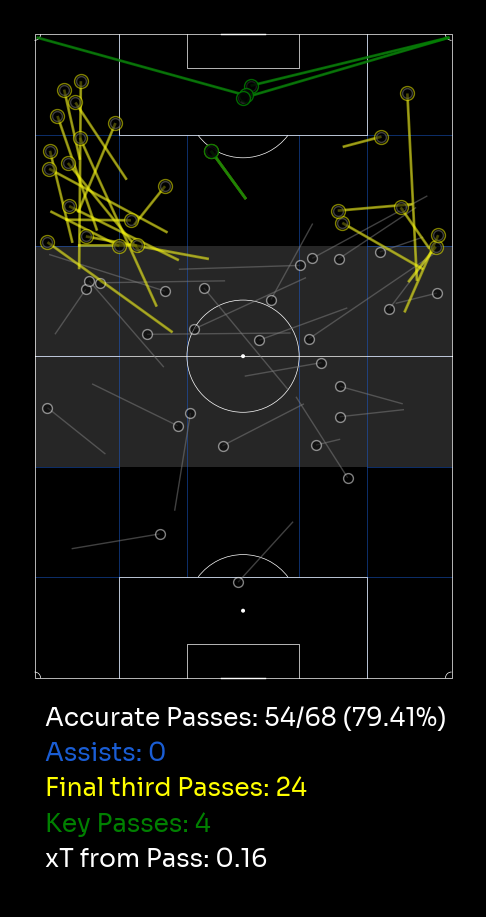

In [106]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
player_passMap(ax, pname,team2_facecolor)

### ShotMap

In [70]:
import requests
import pandas as pd
def scrape_shots(mi):
    headers = {
    'sec-ch-ua-platform': '"Windows"',
    'Referer': 'https://www.fotmob.com/matches/barcelona-vs-benfica/2sv14h',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36',
    'x-mas': 'eyJib2R5Ijp7InVybCI6Ii9hcGkvbWF0Y2hEZXRhaWxzP21hdGNoSWQ9NDczNzU2MyIsImNvZGUiOjE3NDE3MjI0NTc0OTgsImZvbyI6InByb2R1Y3Rpb246YjUzMjA4MzI3ZTlkZDE5NzIzZWM1MTMzYTFjNDdjZDU0NjA3MzJlYy11bmRlZmluZWQifSwic2lnbmF0dXJlIjoiMEI1M0VCN0UwMEU5QzhCOEIzQUE2QkQ4RDkyNjM2MzMifQ==',
    'sec-ch-ua': '"Not(A:Brand";v="99", "Google Chrome";v="133", "Chromium";v="133"',
    'sec-ch-ua-mobile': '?0',} # This headers changes regularly, so you need to get the new header everytime Fotmob change it.

    params = {
    'matchId': mi,
    'showNewUefaBracket': 'true'}

    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params, headers=headers)
    data = response.json()
    shotmap = data['content']['shotmap']['shots']
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi

    return shots_df

In [71]:
df_shots = scrape_shots(4737563)

In [72]:
df_shots['playerName'].unique()

array(['Pedri', 'Lamine Yamal', 'Robert Lewandowski', 'Raphinha',
       'Nicolás Otamendi', 'Dani Olmo', 'Ronald Araujo',
       'Frenkie de Jong', 'Vangelis Pavlidis', 'Ferran Torres',
       'Samuel Dahl', 'Leandro Barreiro', 'Antonio Silva',
       'Renato Sanches', 'Zeki Amdouni', 'Gavi', 'Marc Casado'],
      dtype=object)

In [73]:
df_shots['eventType'].unique()

array(['AttemptSaved', 'Miss', 'Goal'], dtype=object)

In [96]:
def shotMap(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa',half=True, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    #plt.gca().invert_yaxis()
    '''
    shots_df = home_shots_df[home_shots_df['player'] == pname]
    missed = shots_df[shots_df['result'] == 'MissedShots']
    goals = shots_df[shots_df['result'] == 'Goal']
    xG = round(shots_df['expectedGoals'].sum(),2)
    '''
    shots_df = df_shots[df_shots['playerName'] == pname]
    missed = shots_df[shots_df['eventType'] == 'Miss']
    saved = shots_df[shots_df['eventType'] == 'AttemptSaved']
    post = shots_df[shots_df['eventType'] == 'Post']
    goals = shots_df[shots_df['eventType'] == 'Goal']
    xG = round(shots_df['expectedGoals'].sum(),2)
    xGOT = round(shots_df['expectedGoalsOnTarget'].sum(),2)

    pitch.scatter(missed.x,missed.y,marker='o', edgecolors=team_color, s=missed.expectedGoals * 5000, c=background,ax=ax)
    pitch.scatter(saved.x,saved.y,marker='o', edgecolors='white', s=saved.expectedGoals * 5000, c=team_color,zorder=4,ax=ax)
    pitch.scatter(post.x,post.y,marker='o', edgecolors='grey', s=post.expectedGoals * 5000, c=team_color,zorder=5,ax=ax)
    pitch.scatter(goals.x,goals.y,marker='football', edgecolors='white', s=goals.expectedGoals * 5000, c=team_color,ax=ax)

    
    #ax.text(58,108, f"{pname}'s ShotMap", fontsize=30,color='white',fontproperties=font_prop)
    
    ax.text(65,40, f'Total Shots: {shots_df.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,35, f'Goals: {goals.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,30, f'Shots on Target: {saved.shape[0] + goals.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,25, f'Shots off Target: {missed.shape[0]}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,20, f'xG: {xG}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    ax.text(65,15, f'xGOT: {xGOT}', fontsize=18, ha='left', va='center',color='white',fontproperties=font_prop)
    return

### TouchMap

In [58]:
def touchMap(ax, pname,team1_facecolor):
    pitch = VerticalPitch(pitch_type='uefa', half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5, 105.5)
    #ax.set_xlim(-0.5, 68.5)
    #plt.gca().invert_xaxis()

    df_player = df[df['name'] == pname]
    df_player = df_player[~df_player['type'].str.contains('SubstitutionOff|SubstitutionOn|Card|Carry')]
    new_data = pd.DataFrame({'y': [-5, -5, 110, 110], 'x': [-5, 73, 73, -5]})
    df_player = pd.concat([df_player, new_data], ignore_index=True)

    # Get touch coordinates
    touches = df_player[df_player['isTouch'] == 1]
    touches_final_third = touches[touches['x']>=70]
    touch_coords = touches[['x', 'y']].values

    player_touches = df.groupby('name')['isTouch'].count().reset_index()

    # Rename column for clarity
    player_touches.rename(columns={'isTouch': 'total_touches'}, inplace=True)
    
    # Rank players based on total touches (higher touches = better rank)
    player_touches['rank'] = player_touches['total_touches'].rank(method='dense', ascending=False)

    # Calculate mean and standard deviation
    if len(touch_coords) > 0:
        mean_x = np.mean(touch_coords[:, 0])
        mean_y = np.mean(touch_coords[:, 1])
        std_x = np.std(touch_coords[:, 0])
        std_y = np.std(touch_coords[:, 1])

        # Create boundaries for territory
        x_min = mean_x - std_x
        x_max = mean_x + std_x
        y_min = mean_y - std_y
        y_max = mean_y + std_y

        # Filter the points within one standard deviation
        valid_coords = touch_coords[
            (touch_coords[:, 0] >= x_min) & (touch_coords[:, 0] <= x_max) &
            (touch_coords[:, 1] >= y_min) & (touch_coords[:, 1] <= y_max)
        ]

        # Create a convex hull for the filtered points
        if len(valid_coords) > 2:  # Convex hull requires at least 3 points
            hull = ConvexHull(valid_coords)
            hull_points = valid_coords[hull.vertices]

            # Fill the territory with a grey color
            ax.fill(hull_points[:, 1], hull_points[:, 0], color='grey', alpha=0.3)

    # Scatter plot for touches
    ax.scatter(touches.y, touches.x, marker='o', ec=team1_facecolor, s=100, color=background)
    ax.scatter(mean_y, mean_x, marker='o', ec=team1_facecolor, s=1000, color='white', zorder=3)
    ax.text(mean_y + 2, mean_x - 0.8, pname[:2], color=background, fontproperties=font_prop, fontsize=15)

    #ax_text(48, 112, f"TouchMap", color='white', fontproperties=font_prop, fontsize=25, ax=ax)
    ax_text(70, -15, f'''
    Touches: {len(touches)} \n
    <Final Third Touches: {len(touches_final_third)}>\n
    <Rank: {player_touches[player_touches['name']==pname]['rank'].iloc[0]}> \n
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':team1_facecolor}, {'color':'lightgreen'}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)

    # Return touch statistics if needed
    return

2.0


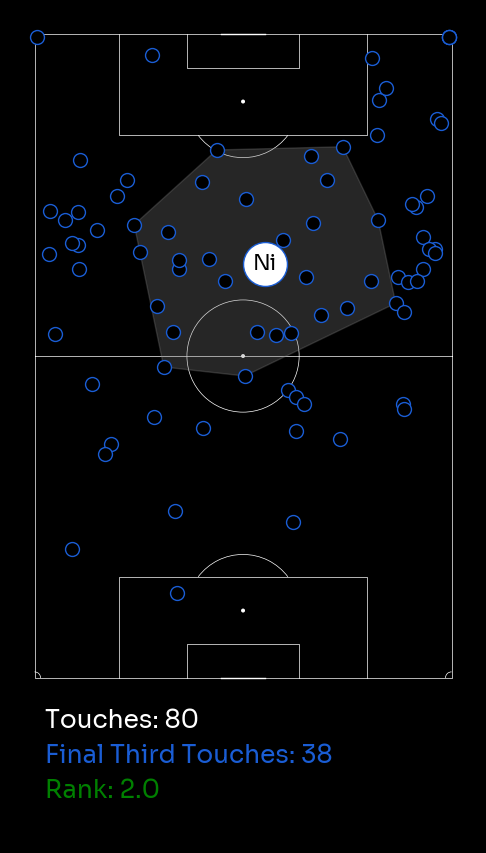

In [116]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
touchMap(ax, pname,team2_facecolor)

### Carries And Dribbles

In [56]:
def individual_carry(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)
    #ax.set_ylim(-0.5, 105.5)
    #ax.set_xlim(-0.5, 68.5)
    #plt.gca().invert_xaxis()

    df_carry = df[(df['type']=='Carry') & (df['name']==pname)]
    led_shot1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('KeyPass'))]
    led_shot2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1).str.contains('Shot'))]
    led_shot = pd.concat([led_shot1, led_shot2])
    led_goal1 = df[(df['type']=='Carry') & (df['name']==pname) & (df['qualifiers'].shift(-1).str.contains('IntentionalGoalAssist'))]
    led_goal2 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Goal')]
    led_goal3 = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-3)=='Goal')]
    led_goal12 = pd.concat([led_goal1, led_goal2])
    led_goal = pd.concat([led_goal12, led_goal3])
    pro_carry = df_carry[(df_carry['prog_carry']>=9.11) & (df_carry['x']>=35)]
    fth_carry = df_carry[(df_carry['x']<70) & (df_carry['endX']>=70)]
    box_entry = df_carry[(df_carry['endX']>=88.5) & (df_carry['endY']>=13.6) & (df_carry['endY']<=54.4) &
                 ~((df_carry['x']>=88.5) & (df_carry['y']>=13.6) & (df_carry['y']<=54.6))]
    disp = df[(df['type']=='Carry') & (df['name']==pname) & (df['type'].shift(-1)=='Dispossessed')]
    df_to = df[(df['type']=='TakeOn') & (df['name']==pname)]
    t_ons = df_to[df_to['outcomeType']=='Successful']
    t_onu = df_to[df_to['outcomeType']=='Unsuccessful']
    df_xT_inc = df_carry[df_carry['xT']>0]
    df_xT_dec = df_carry[df_carry['xT']<0]
    xT_by_Carry = df_carry['xT'].sum().round(2)
    df_carry = df_carry.copy()
    df_carry.loc[:, 'Length'] = np.sqrt((df_carry['x'] - df_carry['endX'])**2 + (df_carry['y'] - df_carry['endY'])**2)
    median_length = round(df_carry['Length'].median(),2)
    total_length = round(df_carry['Length'].sum(),2)
    if len(df_to)!=0:
        success_rate = round((len(t_ons)/len(df_to))*100, 2)
    else:
        success_rate = 0

    for index, row in df_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='white', alpha=0.25, arrowstyle='->', linestyle='--', 
                                   linewidth=2, mutation_scale=15, zorder=2)
        ax.add_patch(arrow)
    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='orange', alpha=0.8, arrowstyle='->', linestyle='--', linewidth=3, 
                                   mutation_scale=20, zorder=3)
        ax.add_patch(arrow)
    for index, row in led_shot.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='yellow', alpha=1, arrowstyle='->', linestyle='--', linewidth=4, 
                                   mutation_scale=20, zorder=4)
        ax.add_patch(arrow)
    for index, row in led_goal.iterrows():
        arrow = patches.FancyArrowPatch((row['y'], row['x']), (row['endY'], row['endX']), color='#c2ff83', alpha=1, arrowstyle='->', linestyle='--', linewidth=4, 
                                   mutation_scale=20, zorder=6)
        ax.add_patch(arrow)

    ax.scatter(t_ons.y, t_ons.x, s=250, color=team_color, edgecolor='white', lw=2, zorder=5)
    ax.scatter(t_onu.y, t_onu.x, s=250, color='None', edgecolor='grey', hatch='/////', lw=1,alpha=0.5, zorder=5)

    #ax_text(68,118,f"{pname}\nCarries And Dribbles", color='white', fontsize=20,fontproperties=font_prop,ax=ax)

    ax_text(70, -6, f'''
    Total Carries: {len(df_carry)}\n
    Carries into Final third: {len(fth_carry)}
    <Progressive Carries: {len(pro_carry)}>\n
    <Carries Led to Shot: {len(led_shot)}>\n
    <Carries Led to Goal: {len(led_goal)}>\n
    <Successful TakeOns: {len(t_ons)}/{len(df_to)}>
''', highlight_textprops=[{'color':'orange'}, {'color':'yellow'}, {'color':'#c2ff83'}, {'color':team_color}],color='white', fontsize=18, ha='left', 
            va='top',fontproperties=font_prop, ax=ax)
    return

### Defensive Actions

In [57]:
def player_defensive(ax, pname,teamcolor):
    pitch = VerticalPitch(pitch_type='uefa',half=False, corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5)
    pitch.draw(ax=ax)

    dfplayer = df[df['name']==pname]
    
    player_tk_s = dfplayer[(dfplayer['type']=='Tackle') & (dfplayer['outcomeType'] == 'Successful')]
    player_tk_u= dfplayer[(dfplayer['type']=='Tackle') & (dfplayer['outcomeType'] != 'Successful')]
    
    player_int_s = dfplayer[((dfplayer['type']=='Interception') | (dfplayer['type']=='BlockedPass')) & (dfplayer['outcomeType'] == 'Successful')]
    player_int_u = dfplayer[((dfplayer['type']=='Interception') | (dfplayer['type']=='BlockedPass')) & (dfplayer['outcomeType'] != 'Successful')]
    
    player_br_s = dfplayer[(dfplayer['type']=='BallRecovery') & (dfplayer['outcomeType'] == 'Successful')]
    player_br_u = dfplayer[(dfplayer['type']=='BallRecovery') & (dfplayer['outcomeType'] != 'Successful')]
    
    player_cl_s = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] == 'Successful')]
    player_cl_u = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] != 'Successful')]

    player_cl_s = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] == 'Successful')]
    player_cl_u = dfplayer[(dfplayer['type']=='Clearance') & (dfplayer['outcomeType'] != 'Successful')]

    player_ar_s = dfplayer[(dfplayer['type']=='Aerial') & (dfplayer['qualifiers'].str.contains('Defensive')) & (dfplayer['outcomeType'] == 'Successful')]
    player_ar_u = dfplayer[(dfplayer['type']=='Aerial') & (dfplayer['qualifiers'].str.contains('Defensive')) & (dfplayer['outcomeType'] != 'Successful')]
    
    pitch.scatter(player_tk_s.x, player_tk_s.y, s=250, c=teamcolor, lw=1.5, edgecolor='white', marker='+', hatch='/////', ax=ax)
    pitch.scatter(player_tk_u.x, player_tk_u.y, s=150, c='grey', lw=1.5, edgecolor='white', marker='+',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_int_s.x, player_int_s.y, s=250, c='#F374E6', lw=1.5, edgecolor='white', marker='s', hatch='/////', ax=ax)
    pitch.scatter(player_int_u.x, player_int_u.y, s=250, c='grey', lw=1.5, edgecolor='white', marker='s',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_br_s.x, player_br_s.y, s=250, c='green', lw=1.5, edgecolor='white', marker='o', hatch='/////', ax=ax)
    pitch.scatter(player_br_u.x, player_br_u.y, s=150, c='grey', lw=1.5, edgecolor='white', marker='o',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_cl_s.x, player_cl_s.y, s=250, c='yellow', lw=1.5, edgecolor='white', marker='d', hatch='/////', ax=ax)
    pitch.scatter(player_cl_u.x, player_cl_u.y, s=150, c='grey', lw=1.5, edgecolor='white', marker='d',alpha=0.5, hatch='/////', ax=ax)
    
    #pitch.scatter(player_fl_s.y, player_fl_s.x, s=250, c=teamcolor, lw=1.5, edgecolor=teamcolor, marker='x', hatch='/////', ax=ax)
    #pitch.scatter(player_fl_u.y, player_fl_u.x, s=150, c='grey', lw=1.5, edgecolor=teamcolor, marker='x',alpha=0.5, hatch='/////', ax=ax)
    
    pitch.scatter(player_ar_s.x, player_ar_s.y, s=250, c='orange', lw=1.5, edgecolor='white', marker='^', hatch='/////', ax=ax)
    pitch.scatter(player_ar_u.x, player_ar_u.y, s=150, c='grey', lw=1.5, edgecolor='white', marker='^',alpha=0.5, hatch='/////', ax=ax)

    #ax_text(68,120,f"{pname}\nDefensive Actions", color='white', fontsize=25,fontproperties=font_prop)

    player_tk_t = len(player_tk_s) + len(player_tk_u)
    player_int_t = len(player_int_s) + len(player_int_u)
    player_ar_t = len(player_ar_s) + len(player_ar_u)
    #<Passes into Penalty box: {len(pen_box)}> \n\n
    ax_text(70, -20, f'''
    <Tackles: {len(player_tk_s)}/{player_tk_t}> \n
    <Interceptions: {len(player_int_s)}/{player_int_t}>\n
    <Ball Recoveries: {len(player_br_s)}> \n
    <Clearances: {len(player_cl_s)}> \n
    <Aerials: {len(player_ar_s)}/{player_ar_t}>
    ''',
    color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':teamcolor}, {'color':'#F374E6'},{'color':'lightgreen'},{'color':'yellow'},{'color':'orange'}],zorder=10, fontsize=18, ha='left', va='center', ax=ax)
    
    return

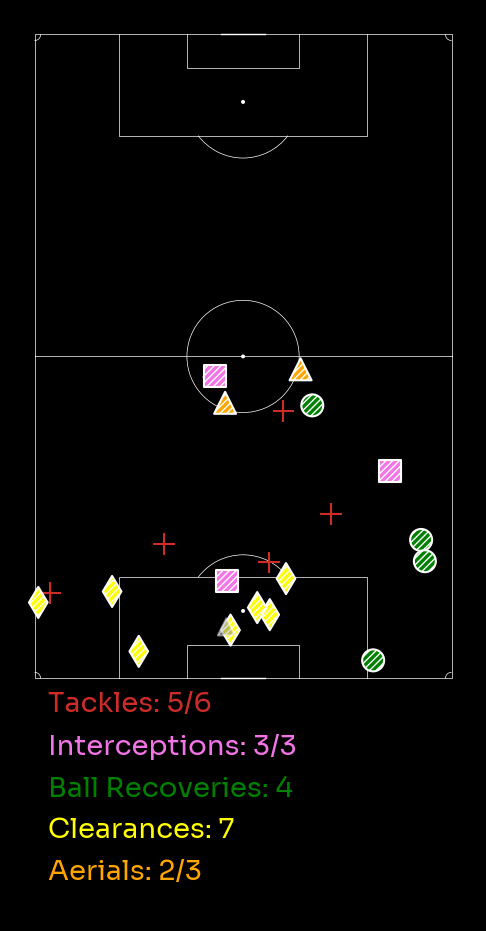

In [191]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor=background)
pname = 'Fikayo Tomori'
player_defensive(ax, pname,team1_facecolor)
#fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/CityVPal/{pname}.png',dpi=500,bbox_inches = 'tight',facecolor=background)

### Passes Received

In [74]:
def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY", "teamName", "playerId", "receiver","qualifiers", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes

In [101]:
def passes_recieved(ax,pname,team_color):
    pitch = VerticalPitch(pitch_type='uefa', corner_arcs=True, pitch_color=background, line_color='white', linewidth=0.5,
                         positional=True, shade_middle=True, positional_color=team_color, shade_color='grey',shade_alpha=0.3,positional_alpha=0.7)
    pitch.draw(ax=ax)
    #plt.gca().invert_xaxis()

    df_passes = get_passes_df(df)
    playerId = df[df['name'] == pname].playerId.unique().tolist()[0]
    filtered_rows = df_passes[(df_passes['type'] == 'Pass') & (df_passes['outcomeType'] == 'Successful') & (df_passes['receiver'] == playerId)]
    keypass_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('KeyPass')]
    assist_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('IntentionalGoalAssist')]
    pr = len(filtered_rows)
    kpr = len(keypass_recieved_df)
    asr = len(assist_recieved_df)

    lc1 = pitch.lines(filtered_rows.x, filtered_rows.y, filtered_rows.endX, filtered_rows.endY, lw=1, transparent=True, comet=False,color='grey', ax=ax, alpha=0.5)
    lc2 = pitch.lines(keypass_recieved_df.x, keypass_recieved_df.y, keypass_recieved_df.endX, keypass_recieved_df.endY, lw=8, transparent=True, comet=True,color='green', ax=ax, alpha=0.8)
    lc3 = pitch.lines(assist_recieved_df.x, assist_recieved_df.y, assist_recieved_df.endX, assist_recieved_df.endY, lw=6, transparent=True, comet=True,color=team_color, ax=ax, alpha=0.9)
    
    sc1 = pitch.scatter(filtered_rows.endX, filtered_rows.endY, s=50, edgecolors='white', linewidths=1, c=background, zorder=2,alpha=0.5, ax=ax)
    sc2 = pitch.scatter(keypass_recieved_df.endX, keypass_recieved_df.endY, s=50, edgecolors='white', linewidths=1, c=background, zorder=2, ax=ax)
    sc3 = pitch.scatter(assist_recieved_df.endX, assist_recieved_df.endY, s=100, edgecolors='white', linewidths=1.5, marker='o', c=team_color, zorder=2, ax=ax)

    ax_text(70,-15, f'''
    <Passes Recieved:{pr+kpr}>\n
    <Assists Recieved:{asr}>\n
    <Keypasses Recieved:{kpr}>
    ''', color='white',fontproperties=font_prop,
    highlight_textprops=[{'color':'white'}, {'color':team_color},{'color':'green'}], fontsize=18, ha='left', va='center', ax=ax)

    return

C:\Users\acer\AppData\Local\Temp\ipykernel_28440\1908219654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "receiver"] = df["playerId"].shift(-1)


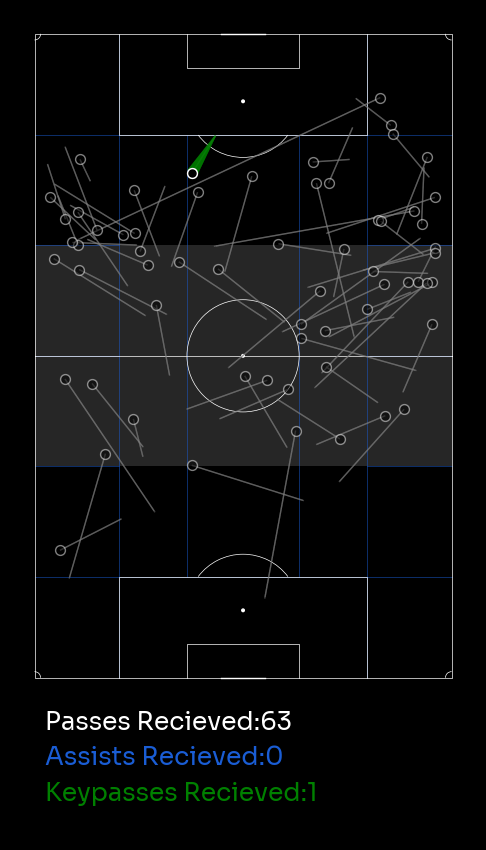

In [102]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
passes_recieved(ax, pname,team2_facecolor)

### GK Analysis

In [122]:
import requests
import pandas as pd

# Define the range of match IDs
match_ids = [12504404]  # Replace with your match ID range

# Initialize an empty list to store shot data
all_shots = []

# Loop through each match ID
for match_id in match_ids:
    url = f'https://www.sofascore.com/api/v1/event/{match_id}/shotmap'
    
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        
        data = response.json()
        
        # Check if 'shotmap' exists and is a list
        if 'shotmap' in data and isinstance(data['shotmap'], list):
            shotmap_data = data['shotmap']
            
            # Normalize and add match ID for reference
            df = pd.json_normalize(shotmap_data, sep='_')
            df['matchId'] = match_id  # Add match ID as a column
            
            all_shots.append(df)  # Store DataFrame in list

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for match {match_id}: {e}")

# Combine all match data into a single DataFrame
if all_shots:
    final_df = pd.concat(all_shots, ignore_index=True)
else:
    final_df = pd.DataFrame()  # Empty DataFrame if no data found

In [124]:
df = final_df.drop(columns = ['draw_start_x', 'draw_start_y', 'draw_end_x',
       'draw_end_y', 'draw_goal_x', 'draw_goal_y', 'blockCoordinates_x',
       'blockCoordinates_y', 'blockCoordinates_z', 'draw_block_x',
       'draw_block_y', 'player_fieldTranslations_nameTranslation_ar',
       'player_fieldTranslations_nameTranslation_hi',
       'player_fieldTranslations_nameTranslation_bn',
       'player_fieldTranslations_shortNameTranslation_ar',
       'player_fieldTranslations_shortNameTranslation_hi',
       'player_fieldTranslations_shortNameTranslation_bn'],axis=1)

In [125]:
df.columns

Index(['isHome', 'shotType', 'goalType', 'situation', 'bodyPart',
       'goalMouthLocation', 'xg', 'xgot', 'id', 'time', 'addedTime',
       'timeSeconds', 'reversedPeriodTime', 'reversedPeriodTimeSeconds',
       'incidentType', 'player_name', 'player_firstName', 'player_lastName',
       'player_slug', 'player_shortName', 'player_position',
       'player_jerseyNumber', 'player_userCount', 'player_id',
       'playerCoordinates_x', 'playerCoordinates_y', 'playerCoordinates_z',
       'goalMouthCoordinates_x', 'goalMouthCoordinates_y',
       'goalMouthCoordinates_z', 'matchId'],
      dtype='object')

In [143]:
df[df['shotType'] == 'miss'][['goalMouthCoordinates_y','goalMouthCoordinates_z','mapped_x','mapped_y','player_name']]

,goalMouthCoordinates_y,goalMouthCoordinates_z,mapped_x,mapped_y,player_name
3,44.000000,70.8,33.400000,3.540,Francesco Camarda
6,59.000000,8.3,34.900000,0.415,Henrikh Mkhitaryan
19,12.725422,76.4,30.272542,3.820,Lautaro Martínez
20,100.000000,48.6,39.000000,2.430,Lautaro Martínez
21,28.310794,29.2,31.831079,1.460,Lautaro Martínez


In [126]:
team1_shots_faced = df[df['isHome'] == False]
team2_shots_faced = df[df['isHome'] == True]



array([ True, False])

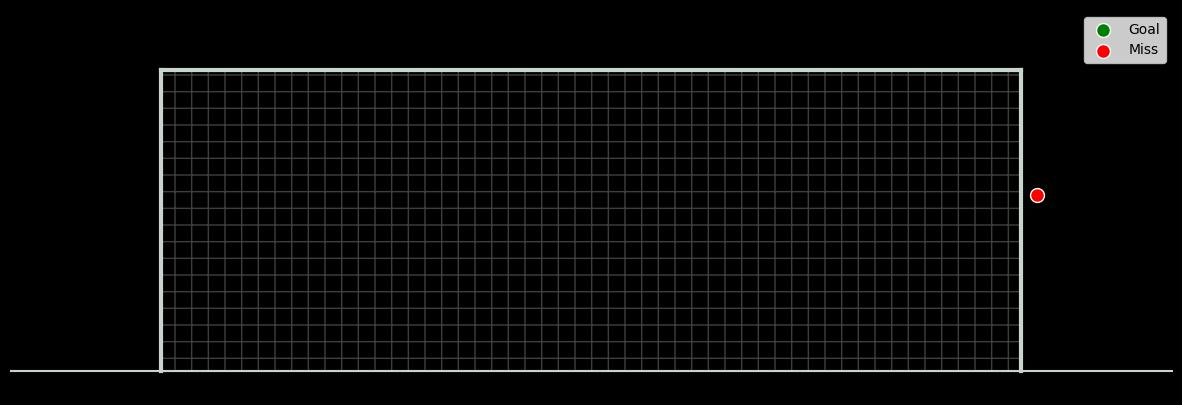

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch, FontManager
from mplsoccer import Sbopen
from matplotlib.patches import Rectangle

#Create figure
fig=plt.figure(facecolor='black')
fig.set_size_inches(15, 5)

df['mapped_x'] = 35 + (df['goalMouthCoordinates_y'] / 100) * 10  # Scale to goal width
df['mapped_y'] = (df['goalMouthCoordinates_z'] / 100) * 5 # Scale up to extend beyond 2.5


#plt.gca().invert_xaxis()

# Goal post lines (shifted to the left by 1 unit)
plt.plot([29, 39], [0, 0], color='#c7d5cc', linewidth=1.5)
plt.plot([30.3, 37.7], [2.5, 2.5], color='#c7d5cc', linewidth=3)
plt.plot([37.7, 37.7], [0, 2.5], color='#c7d5cc', linewidth=3)
plt.plot([30.3, 30.3], [0, 2.5], color='#c7d5cc', linewidth=3)

# Goal net (shifted to the left by 1 unit)
plt.gca().add_patch(Rectangle((30.3, 0), 7.4, 2.5, fill=False, edgecolor='#c7d5cc', hatch='+', alpha=0.3))

#plt.gca().invert_yaxis()
#Tidy Axes
plt.axis('off')

goal_mask = (df['shotType'] == 'goal')
sc1 = plt.scatter(df.loc[goal_mask, 'mapped_x'], df.loc[goal_mask, 'mapped_y'],marker='o', color='green', label='Goal',s=100,zorder=2,edgecolors = 'white',linewidths=1)


miss_mask = (df['shotType'] == 'miss')
sc2 = plt.scatter(df.loc[miss_mask, 'mapped_x'], df.loc[miss_mask, 'mapped_y'],marker='o', color='red', label='Miss',s=100,zorder=2,edgecolors = 'white',linewidths=1)

plt.ylim(ymin=-0.2, ymax=3)
plt.xlim(xmin=29, xmax=39)
plt.legend(loc='best')

#plt.savefig('C:/Users/acer/Desktop/IndianCityzen/Projects/Images/ShotMaps/FodenShotMap.png',dpi=300,bbox_inches = 'tight',facecolor='black')

In [120]:
def plot_goalPost(ax):
    df_team1['goalCrossedZ'] = df_team1['goalCrossedZ']*0.75
    #aShotsdf['goalMouthZ'] = (aShotsdf['goalMouthZ']*0.75) + 38

    df_team1['goalCrossedY'] = (37.66 - df_team1['goalCrossedY'])*12.295
    #aShotsdf['goalMouthY'] = (37.66 - aShotsdf['goalMouthY'])*12.295
    # plotting an invisible pitch using the pitch color and line color same color, because the goalposts are being plotted inside the pitch using pitch's dimension
    pitch = Pitch(pitch_type='uefa', goal_type='box', goal_alpha=.75, corner_arcs=True, pitch_color=background, line_color=background, linewidth=2)
    pitch.draw(ax=ax)
    
    # away goalpost lines
    ax.plot([0, 0], [-1, 30], color='white', linewidth=5)
    ax.plot([0, 90], [30, 30], color='white', linewidth=5)
    ax.plot([90, 90], [30, -1], color='white', linewidth=5)
    ax.plot([-2, 92], [-2, -2], color='white', linewidth=3)
    # home goalpost lines
    ax.plot([0, 0], [37, 68], color='white', linewidth=5)
    ax.plot([0, 90], [68, 68], color='white', linewidth=5)
    ax.plot([90, 90], [68, 37], color='white', linewidth=5)
    ax.plot([-2, 92], [36, 36], color='white', linewidth=3)
    
    # filtering different types of shots
    df_team1_saved = df_team1[df_team1['eventType'] == 'AttemptSaved']
    df_team1_headers_saved = df_team1_headers[df_team1_headers['eventType'] == 'AttemptSaved']

    df_team2_saved = df_team2[df_team2['eventType'] == 'AttemptSaved']
    df_team2_headers_saved = df_team2_headers[df_team2_headers['eventType'] == 'AttemptSaved']
    
    # scattering those shots
    sc1 = pitch.scatter(df_team1_saved.goalCrossedY, df_team1_saved.goalCrossedZ, marker='o', c=team1_facecolor, edgecolor='white', hatch='/////', s=400, ax=ax)
    #sc2 = pitch.scatter(df_team1_headers_saved.goalMouthY, df_team1_headers_saved.goalMouthZ, marker='football', c='None', edgecolors='green', s=550, ax=ax)
    #sc3 = pitch.scatter(df_team2_saved.x_og, df_team2_saved.y_og, marker='o', c=team2_facecolor, edgecolors='yellow', hatch='/////', s=400, ax=ax)
    #sc4 = pitch.scatter(df_team2_headers_saved.goalMouthY, df_team2_headers_saved.goalMouthZ, marker='o', c='None', edgecolor=teamcolor, hatch='/////', s=400, ax=ax)
    #sc5 = pitch.scatter(aGoaldf.goalMouthY, aGoaldf.goalMouthZ, marker='football', c='None', edgecolors='green', s=550, ax=ax)
    #sc6 = pitch.scatter(aPostdf.goalMouthY, aPostdf.goalMouthZ, marker='o', c='None', edgecolors='orange', hatch='/////', s=400, ax=ax)
    
    # Headlines and other texts
    ax.text(0, 70, f"Home team GK saves", color=team1_facecolor, fontsize=30, ha='left', fontweight='bold')
    ax.text(0, -3, f"Away team GK saves", color=team2_facecolor, fontsize=30, ha='left', va='top', fontweight='bold')
    
    #ax.text(92, 68, f"xGOT faced = {axgot}\nShots Saved = {len(aSavedf)}\nGoals Conceded = {len(aGoaldf)}\nGoals Prevented = {round(axgot - len(aGoaldf),2)}",
          #color=teamcolor, fontsize=15, va='top', ha='left')
    #ax.text(92, 30, f"xGOT faced = {hxgot}\nShots Saved = {len(hSavedf)}\nGoals Conceded = {len(hGoaldf)}\nGoals Prevented = {round(hxgot - len(hGoaldf),2)}",
          #color=acol, fontsize=15, va='top', ha='left')
    
    sc7  = pitch.scatter(94, 48, marker='o', c='None', edgecolor=team1_facecolor, hatch='/////', s=150, ax=ax)
    sc8  = pitch.scatter(94, 53, marker='football', c='None', edgecolors='green', s=150, ax=ax)
    sc9  = pitch.scatter(94, 43, marker='o', c='None', edgecolors='orange', hatch='/////', s=150, ax=ax)
    sc10 = pitch.scatter(94, 10, marker='o', c='None', edgecolor=team2_facecolor, hatch='/////', s=150, ax=ax)
    sc11 = pitch.scatter(94, 15, marker='football', c='None', edgecolors='green', s=150, ax=ax)
    sc12 = pitch.scatter(94, 5, marker='o', c='None', edgecolors='orange', hatch='/////', s=150, ax=ax)
    
    ax.text(96, 53, "Goal Conceded", color='green', fontsize=15, va='center')
    ax.text(96, 48, "Saved shot", color=team1_facecolor, fontsize=15, va='center')
    ax.text(96, 43, "Shot on post", color='orange', fontsize=15, va='center')
    
    ax.text(96, 15, "Goal Conceded", color='green', fontsize=15, va='center')
    ax.text(96, 10, "Saved shot", color=team2_facecolor, fontsize=15, va='center')
    ax.text(96, 5, "Shot on post", color='orange', fontsize=15, va='center')

    return

KeyError: 'goalCrossedZ'

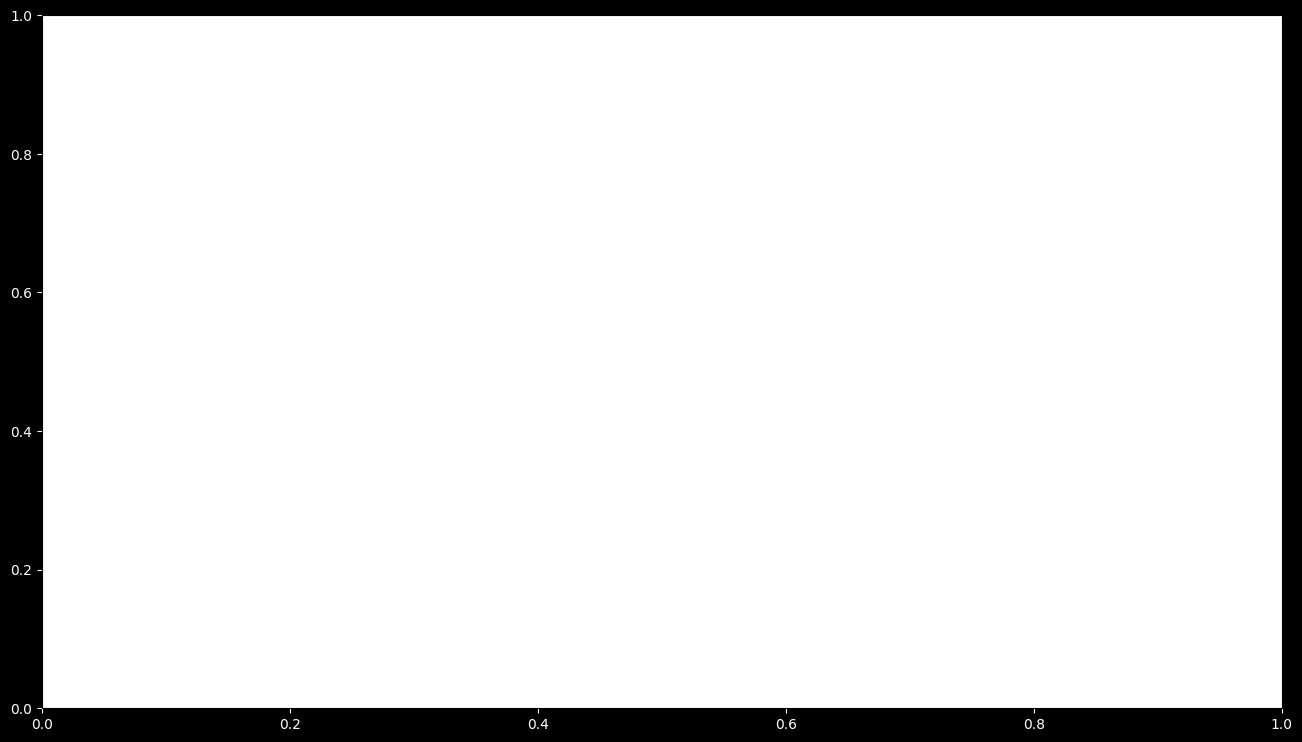

In [121]:
fig,ax=plt.subplots(figsize=(16,9),facecolor=background)
plot_goalPost(ax)

### Viz

In [54]:
df['teamName'].unique()

array(['Aston Villa', 'Man City'], dtype=object)

Text(0.5, 1.0, 'Defensive Actions')

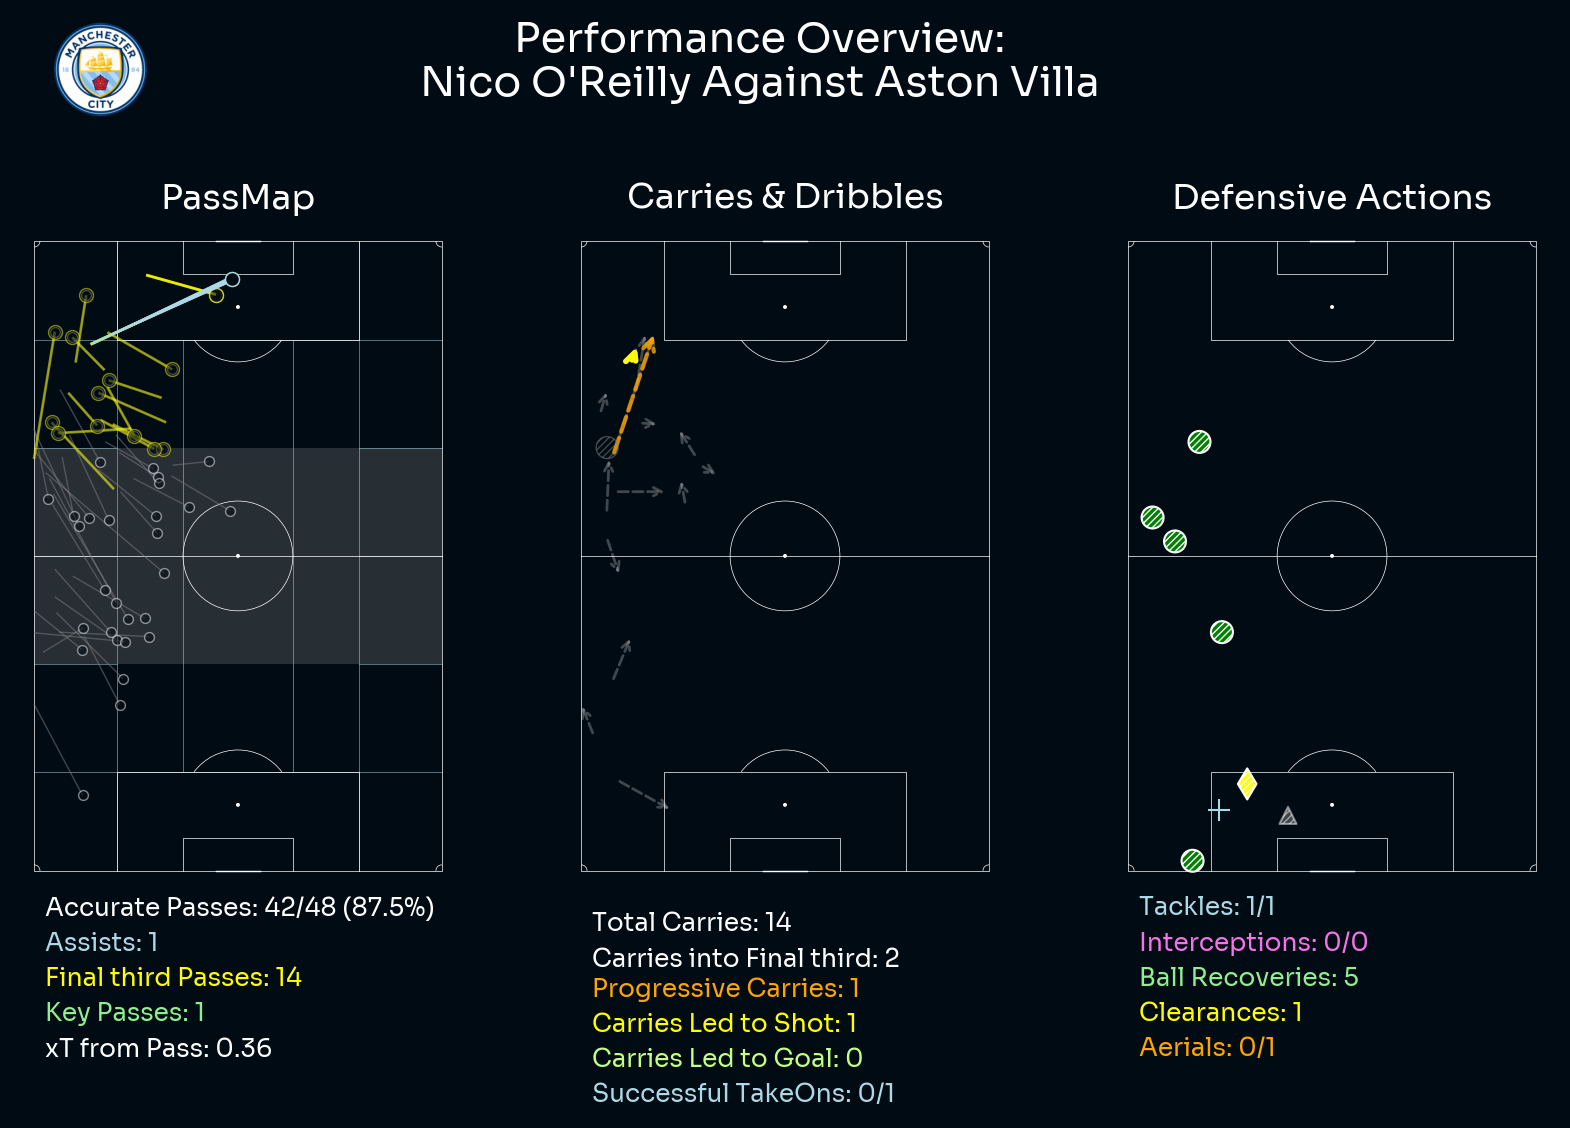

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(20, 12), facecolor=background)
pname = "Nico O'Reilly"
hteam = 'Man City'
ateam = 'Aston Villa'
#p1name = 'Kylian Mbappe'
#p2name = 'Vinicius Junior'
#p3name = 'Rodrygo'
team1_facecolor = 'lightblue'
fig.suptitle(f'Performance Overview:\n{pname} Against {ateam}', fontsize=30,fontproperties=font_prop, color='white', y=0.94)
#fig.suptitle(f"{team2_name}'s Front Three Against {team2_name}\n (Carries And Dribbles)", fontsize=30,fontproperties=font_prop, color='white', y=0.92)
#team1_name = 'Man City'
img_team1 = mpimg.imread(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/Images/TeamLogos/{hteam}.png')
ax_image = add_image(
    img_team1, fig, left=0.12, bottom=0.85, width=0.1, height=0.1,aspect='equal'
)

#ax_image = add_image(
#    logo, fig, left=0.82, bottom=0.85, width=0.08, height=0.08,aspect='equal'
#)

player_passMap(axes[0], pname,team1_facecolor)
axes[0].set_title(f'PassMap', color='white',fontproperties=font_prop,fontsize=25)


#touchMap(axes[1], pname,team1_facecolor)
#axes[1].set_title(f'TouchMap', color='white',fontproperties=font_prop,fontsize=25)


#passes_recieved(axes[2], pname,team2_facecolor)
#axes[2].set_title(f'Passes Received', color='white',fontproperties=font_prop,fontsize=25)

#team2_facecolor = 'orange'

individual_carry(axes[1], pname,team1_facecolor)
axes[1].set_title(f'Carries & Dribbles', color='white',fontproperties=font_prop,fontsize=25)

#individual_carry(axes[1], p1name,team2_facecolor)
#axes[1].set_title(f'{p1name}', color='white',fontproperties=font_prop,fontsize=25)

#individual_carry(axes[2], p3name,team2_facecolor)
#axes[2].set_title(f'{p3name}', color='white',fontproperties=font_prop,fontsize=25)

#shotMap(axes[0], pname,team1_facecolor)
#axes[0].set_title(f'ShotMap', color='white',fontproperties=font_prop,fontsize=25)

player_defensive(axes[2], pname,team1_facecolor)
axes[2].set_title(f'Defensive Actions', color='white',fontproperties=font_prop,fontsize=25)

#fig.savefig(f'C:/Users/acer/Documents/GitHub/IndianCitizen/ScorePredict/MatchReports/City/{pname}.png',dpi=500,bbox_inches = 'tight',facecolor=background)